# Package initiation

In [1]:
%load_ext autoreload
%autoreload 2

import os
import re
import shutil
import random
import pprint
import itertools
import functools
import collections

import pysam
import pyranges as pr
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import scipy.stats

import sys
sys.path.append('/home/users/pjh/scripts/python_genome_packages')

In [2]:
from handygenome import common
from handygenome.common import ChromDict, Vcfspec, Interval
from handygenome.variantplus.breakends import Breakends
from handygenome.variantplus.variantplus import VariantPlus, VariantPlusList
from handygenome.variantplus.vcfplus import VcfPlus
from handygenome.igvhandle import IGVHandle

from handygenome.variantplus import vpfilter as libvpfilter
from handygenome.vcfeditor.initvcf import create_header

In [3]:
FASTA_PATH_HG19 = "/home/users/data/01_reference/human_g1k_v37/human_g1k_v37.fasta"
FASTA_PATH_HG38 = "/home/users/data/01_reference/human_g1k_v38/Homo_sapiens_assembly38.fasta"

FASTA_HG19 = pysam.FastaFile(FASTA_PATH_HG19)
FASTA_HG38 = pysam.FastaFile(FASTA_PATH_HG38)
CHROMDICT_HG19 = ChromDict(fasta_path=FASTA_PATH_HG19)
CHROMDICT_HG38 = ChromDict(fasta_path=FASTA_PATH_HG38)

# Basic setups

In [457]:
SAMPLEIDS = [
    '14', '6', '87', 'F13', 'F2', 'F33', 'F37', 'FF1', 'FF104', 'FF115', 'FF13', 'FF18', 'FF20', 'FF21', 'FF23', 'FF24', 'FF27', 
    'FF3', 'FF31', 'FF34', 'FF37', 'FF39', 'FF4', 'FF43', 'FF53', 'FF56', 'FF57', 'FF58', 'FF6', 'FF62', 'FF67', 'FF71', 'FF76', 
    'FF77', 'FF78', 'FF79', 'FF80', 'FF85', 
    #'IO04',  # swapped sample
    'IO05', 'IO06', 'IO07', 'IO08', 'IO09', 'IO12', 'IO13', 'IO15', 'IO16', 'IO17', 
    'IO18', 'IO22', 'IO23', 'IO24', 'IO25', 'SC126', 'SC134', 'SC31', 'SC81', 'SC88', 'SC97', 'SC98', 
]
SAMPLEIDS_LU = [f'LU-{x}' for x in SAMPLEIDS]
SAMPLEIDS_LU_PANEL = [f'{x}_panel' for x in SAMPLEIDS_LU]
SAMPLEIDS_LU_TUMOR = [f'{x}_tumor' for x in SAMPLEIDS_LU]

BAM_TOPDIR = '/home/users/team_projects/Lung_Cancer_Panel_data/03_Data_from_YTKim/02_BAM/'
PANEL_REGION_PATH = '/home/users/team_projects/Lung_Cancer_Panel_data/03_Data_from_YTKim/metadata/panel_bait_design/custom/exon_intron_targetregions_merged.bed'
PANEL_REGION_EXONS_PATH = '/home/users/team_projects/Lung_Cancer_Panel_data/03_Data_from_YTKim/metadata/panel_bait_design/custom/SNUH_FIRST_Lung_Cancer_V5_exon_Regions_tracknamechanged.bed'
PANEL_REGION_INTRONS_PATH = '/home/users/team_projects/Lung_Cancer_Panel_data/03_Data_from_YTKim/metadata/panel_bait_design/custom/SNUH_FIRST_Lung_Cancer_V5_intron_Regions_tracknamechanged.bed'
WGS_TMB_PATH = '/home/users/team_projects/Lung_Cancer_Panel_data/03_Data_from_YTKim/metadata/wgs_TMB_previously_found_210312.txt'

In [368]:
BAM_PATHS = {'normal': dict(), 'tumor': dict(), 'panel': dict()}
for top, dirs, files in os.walk(BAM_TOPDIR):
    for f in files:
        for sampleid in SAMPLEIDS_LU:
            for sampletype in ('tumor', 'normal', 'panel'):
                if f == f'{sampleid}.{sampletype}.bam':
                    BAM_PATHS[sampletype][sampleid] = os.path.join(top, f)

In [369]:
BAMS = {sampletype: {sampleid: pysam.AlignmentFile(bampath) 
                     for sampleid, bampath in bampathdic.items()}
        for sampletype, bampathdic in BAM_PATHS.items()}

In [7]:
PANEL_REGION_GR = pr.read_bed(PANEL_REGION_PATH)

In [8]:
WHOLE_GENOME_LENGTH = 3_095_677_412
PANEL_REGION_LENGTH = 1_890_272

In [9]:
igv = IGVHandle(60387)

# Scratches

# Setup convenience functions

#### show_vp functions

In [10]:
def load_bams(sampleid):
    igv.load([BAM_PATHS['normal'][sampleid], BAM_PATHS['tumor'][sampleid], BAM_PATHS['panel'][sampleid]])

In [11]:
def show_vp_igv(vp, sampleid):
    igv.cmd('new')
    igv.load([PANEL_REGION_PATH, PANEL_REGION_EXONS_PATH, PANEL_REGION_INTRONS_PATH])
    load_bams(sampleid)

    igv.goto([vp.vcfspec], width=200)
    igv.cmd('viewaspairs')
    igv.cmd('sort base')

#### others

In [12]:
def sypark_vcf_iterator(vcf_path):
    for linedict in common.fileiter(vcf_path, sep='\t'):
        linedict['POS'] = int(linedict['POS'])
        yield linedict

#### for calculating the distance from the nearest bait end 

In [13]:
def get_bait_end_distance(vp):
    ovlp_bait_gr = PANEL_REGION_GR.overlap(vp.get_gr())
    distance = min(abs(vp.vr.start - ovlp_bait_gr.Start[0]),
                   abs(vp.vr.start - (ovlp_bait_gr.End[0] - 1)))
    
    return distance

# Handle previous wgs vcfs

#### Set previous wgs vcf paths - snv

In [14]:
SYPARK_VCF_PATHS = dict()

SYPARK_VCF_TOPDIR = '/home/users/sypark/00_Project/05_Rearrangement/19_revision_total_samples/01_snv'
for fname in os.listdir(SYPARK_VCF_TOPDIR):
    if fname.startswith('LU-'):
        sampleid = fname.split('.')[0]
        if sampleid in SAMPLEIDS_LU:
            SYPARK_VCF_PATHS[sampleid] = os.path.join(SYPARK_VCF_TOPDIR, fname)
            
SYPARK_VCF_TOPDIR2 = '/home/users/sypark/00_Project/05_Rearrangement/19_revision_total_samples/01_snv/deprecated/'
for fname in os.listdir(SYPARK_VCF_TOPDIR2):
    if fname.startswith('LU-'):
        sampleid = fname.split('.')[0]
        if sampleid in SAMPLEIDS_LU and sampleid not in SYPARK_VCF_PATHS.keys():
            SYPARK_VCF_PATHS[sampleid] = os.path.join(SYPARK_VCF_TOPDIR2, fname)
            
IO_VCF_PATHS = dict()
IO_VCF_TOPDIR = '/home/users/team_projects/Lung_Cancer_Panel_data/03_Data_from_YTKim/links_other_projects/LungCancer_IO_WGS/01_WGS/07_pointMT/01_snv'
# sampleids_io_modified = ['SNU_LC_IO_' + re.sub('LU-IO', '', x)
#                          for x in SAMPLEIDS_LU 
#                          if x.startswith('LU-IO')]
alias_dict = {'LU-IO02': 'LU-F33',
              'LU-IO14': 'LU-FF80',
              'LU-IO21': 'LU-SC134',
              'LU-IO01': 'LU-SC31',
              'LU-IO19': 'LU-SC88',
              'LU-IO20': 'LU-SC98',
              }
for fname in os.listdir(IO_VCF_TOPDIR):
    if fname.endswith('.anv.occ.fi'):
        sampleid = 'LU-IO' + fname.split('.')[0].split('_')[-1]
        if sampleid in alias_dict:
            sampleid = alias_dict[sampleid]
            
        if sampleid in SAMPLEIDS_LU:
            IO_VCF_PATHS[sampleid] = os.path.join(IO_VCF_TOPDIR, fname)

PREVIOUS_VCF_PATHS = dict()
PREVIOUS_VCF_PATHS.update(SYPARK_VCF_PATHS)
PREVIOUS_VCF_PATHS.update(IO_VCF_PATHS)

PREVIOUS_VCF_PATHS_SNV = PREVIOUS_VCF_PATHS

#### Set previous wgs vcf paths - indel

In [15]:
SYPARK_VCF_PATHS = dict()

SYPARK_VCF_TOPDIR = '/home/users/sypark/00_Project/05_Rearrangement/19_revision_total_samples/03_indel/final'
for fname in os.listdir(SYPARK_VCF_TOPDIR):
    if fname.startswith('LU-') and fname.endswith('.fi'):
        sampleid = fname.split('.')[0]
        if sampleid in SAMPLEIDS_LU:
            SYPARK_VCF_PATHS[sampleid] = os.path.join(SYPARK_VCF_TOPDIR, fname)            

SYPARK_VCF_TOPDIR2 = '/home/users/sypark/00_Project/05_Rearrangement/19_revision_total_samples/03_indel/final/deprecated'
for fname in os.listdir(SYPARK_VCF_TOPDIR2):
    if fname.startswith('LU-'):
        sampleid = fname.split('.')[0]
        if sampleid in SAMPLEIDS_LU and sampleid not in SYPARK_VCF_PATHS.keys():
            SYPARK_VCF_PATHS[sampleid] = os.path.join(SYPARK_VCF_TOPDIR2, fname)

IO_VCF_PATHS = dict()
IO_VCF_TOPDIR = '/home/users/team_projects/Lung_Cancer_Panel_data/03_Data_from_YTKim/links_other_projects/LungCancer_IO_WGS/01_WGS/07_pointMT/02_indel'
alias_dict = {'LU-IO02': 'LU-F33',
              'LU-IO14': 'LU-FF80',
              'LU-IO21': 'LU-SC134',
              'LU-IO01': 'LU-SC31',
              'LU-IO19': 'LU-SC88',
              'LU-IO20': 'LU-SC98',
              }
for fname in os.listdir(IO_VCF_TOPDIR):
    if fname.endswith('.anv.occ.fi'):
        sampleid = 'LU-IO' + fname.split('.')[0].split('_')[-1]
        if sampleid in alias_dict:
            sampleid = alias_dict[sampleid]
            
        if sampleid in SAMPLEIDS_LU:
            IO_VCF_PATHS[sampleid] = os.path.join(IO_VCF_TOPDIR, fname)

PREVIOUS_VCF_PATHS = dict()
PREVIOUS_VCF_PATHS.update(SYPARK_VCF_PATHS)
PREVIOUS_VCF_PATHS.update(IO_VCF_PATHS)

PREVIOUS_VCF_PATHS_INDEL = PREVIOUS_VCF_PATHS

#### Write previous files into VCFs

In [100]:
from handygenome.variantplus.varianthandler import apply_vcfspec

def prev_wgs_to_vcf(prev_file_path, new_path):
    vcfspec_list = list()
    hdr = create_header(chromdict=CHROMDICT_HG19)
    with pysam.VariantFile(new_path, mode='wz', header=hdr) as out_vcf:
        for linedict in sypark_vcf_iterator(prev_file_path):
            for alt in linedict['ALT'].split(','):            
                vcfspec = Vcfspec(chrom=linedict['CHROM'], pos=linedict['POS'], ref=linedict['REF'], alts=(alt,))
                vcfspec_list.append(vcfspec)
                
        for vcfspec in sorted(vcfspec_list, key=common.get_vcfspec_sortkey(CHROMDICT_HG19)):
            vr = out_vcf.header.new_record()
            apply_vcfspec(vr, vcfspec)
            out_vcf.write(vr)

In [101]:
previous_wgs_vcf_dir = '/home/users/team_projects/Lung_Cancer_Panel_data/03_Data_from_YTKim/09_short_variants_union/previous_wgs_results'

for sampleid in SAMPLEIDS_LU:
    print(sampleid)
    
    new_path_snv = os.path.join(previous_wgs_vcf_dir, f'{sampleid}.snv.vcf.gz')
    prev_wgs_to_vcf(PREVIOUS_VCF_PATHS_SNV[sampleid], new_path_snv)
    
    new_path_indel = os.path.join(previous_wgs_vcf_dir, f'{sampleid}.indel.vcf.gz')
    prev_wgs_to_vcf(PREVIOUS_VCF_PATHS_INDEL[sampleid], new_path_indel)

LU-14
LU-6
LU-87
LU-F13
LU-F2
LU-F33
LU-F37
LU-FF1
LU-FF104
LU-FF115
LU-FF13
LU-FF18
LU-FF20
LU-FF21
LU-FF23
LU-FF24
LU-FF27
LU-FF3
LU-FF31
LU-FF34
LU-FF37
LU-FF39
LU-FF4
LU-FF43
LU-FF53
LU-FF56
LU-FF57
LU-FF58
LU-FF6
LU-FF62
LU-FF67
LU-FF71
LU-FF76
LU-FF77
LU-FF78
LU-FF79
LU-FF80
LU-FF85
LU-IO04
LU-IO05
LU-IO06
LU-IO07
LU-IO08
LU-IO09
LU-IO12
LU-IO13
LU-IO15
LU-IO16
LU-IO17
LU-IO18
LU-IO22
LU-IO23
LU-IO24
LU-IO25
LU-SC126
LU-SC134
LU-SC31
LU-SC81
LU-SC88
LU-SC97
LU-SC98


# INDEL analysis

### Load vcf

In [16]:
PANEL_VCF_INDEL_PATH = '/home/users/team_projects/Lung_Cancer_Panel_data/03_Data_from_YTKim/09_short_variants_union/220707_indel/02_union/panel_indel_union.annot.readstats_again.vcf.gz'

In [17]:
vcfp_indel = VcfPlus(PANEL_VCF_INDEL_PATH, set_annotdb=True, set_readstats=True, logging_lineno=1000)

[KST 2022-07-15 01:18:15 INFO] handygenome.variantplus.vcfplus: 1000 variant records processed
[KST 2022-07-15 01:18:51 INFO] handygenome.variantplus.vcfplus: 2000 variant records processed


### Setup filter objects

In [561]:
fi_popfreq = libvpfilter.PopfreqFilter(cutoff=0.01, popnames=("GnomAD", "1000Genomes", "KOREAN", "Korea1K"))
fi_diffBQ = libvpfilter.DiffMeanBQFilter(cutoff=-5)
fi_BQ = libvpfilter.AbsMeanBQFilter(cutoff=20)
fi_diffMQ = libvpfilter.DiffMeanMQFilter(cutoff=-15)
fi_MQ = libvpfilter.AbsMeanMQFilter(cutoff=40)
fi_clipovlp = libvpfilter.ClipoverlapFilter(cutoff=1)
fi_varposunif = libvpfilter.VarposUniformFilter(cutoff=0.05)
fi_readcount = libvpfilter.ReadcountFilter(cutoff=2)
fi_otherratio = libvpfilter.OthercountRatioFilter(cutoff=1.5)

ponfilter_params = {
    'deviation_cutoff': 5, 
    'subset_num_cutoff': 3, 
    'subset_fraction': 0.5,
    'germline_vaf_cutoff': 0.2,
    'germline_sample_ratio_cutoff': 0.2,
    'mode': 'mean',
}

In [562]:
nonsw_filist = [
    fi_popfreq, 
]
sw_filist = [
    fi_diffBQ,
    fi_BQ,
    fi_diffMQ,
    fi_MQ,
    fi_clipovlp,
#     fi_varposunif,
    fi_readcount,
    fi_otherratio,
]

### Setup vp filter functions

In [563]:
def show_filter_results(vp, sampleid):
    for fi in nonsw_filist:
        fi.show_result(vp)
    for fi in sw_filist:
        fi.show_result(vp, sampleid)

In [564]:
def allfilter(vp, sampleid):
    fi_pon = vp.get_ponfilter(sampleids=SAMPLEIDS_LU_PANEL, **ponfilter_params)
    mask_all = all([
        fi_pon.check(vp, sampleid),
        fi_popfreq.check(vp),
        fi_diffBQ.check(vp, sampleid),
        fi_BQ.check(vp, sampleid),
        fi_diffMQ.check(vp, sampleid),
        fi_MQ.check(vp, sampleid),
        fi_clipovlp.check(vp, sampleid),
        fi_readcount.check(vp, sampleid),
        (len(vp.vcfspec.ref) >= 4 or
         fi_otherratio.check(vp, sampleid)),
    ])
    
    return mask_all

def cosmicfilter(vp):
    return vp.get_cosmic_total_occur() > 20

def readcountfilter(vp, sampleid):
    return fi_readcount.check(vp, sampleid)

def PONfilter(vp, sampleid):
    return vp.get_ponfilter(SAMPLEIDS_LU_PANEL, **ponfilter_params).check(vp, sampleid)

def functionalfilter(vp):
    return any(
        any(feature['consequence_flags'][key] for key in (
#             'is_3pUTR_involved', 
#             'is_5pUTR_involved', 
            'is_protein_altering',
        ))
        for feature in vp.annotdb.transcript_canon_ovlp.values()
    )

### Filter entire VCF

In [533]:
def vpfilter(vp):
    sampleid = 'LU-87_panel'
    return functionalfilter(vp) and any(readcountfilter(vp, sampleid) for sampleid in SAMPLEIDS_LU_PANEL)
#     return cosmicfilter(vp)
#     return (readcountfilter(vp, sampleid) and PONfilter(vp, sampleid))
#     return allfilter(vp, sampleid)


vcfp_indel.filter_vplist(vpfilter)
print(len(vcfp_indel.vplist_filtered))

82


### Pick vp and inspect

In [534]:
# vp = vcfp_indel.vplist_filtered.sample()
vplist_filtered = vcfp_indel.vplist_filtered.sample(20)

In [535]:
idx = -1

In [570]:
idx += 1
print(idx)
# vp = vcfp_indel.vplist_filtered[idx]
vp = vplist_filtered[idx]

3


### inspect vp

In [551]:
print(vp)

<VariantPlus object (9	87359892	.	TGGAA	T)>


In [450]:
print(vp.annotdb.popfreq)

{'1000Genomes': None,
 'ALSPAC': None,
 'Chileans': None,
 'ChromosomeY': None,
 'Daghestan': None,
 'Estonian': None,
 'ExAC': None,
 'FINRISK': None,
 'GENOME_DK': None,
 'GnomAD': None,
 'GnomAD_exomes': None,
 'GoESP': None,
 'GoNL': None,
 'HGDP_Stanford': None,
 'HapMap': None,
 'KOREAN': None,
 'Korea1K': None,
 'MGP': None,
 'NorthernSweden': None,
 'PAGE_STUDY': None,
 'PRJEB36033': None,
 'PRJEB37584': None,
 'PRJEB37766': None,
 'PharmGKB': None,
 'Qatari': None,
 'SGDP_PRJ': None,
 'Siberian': None,
 'TOMMO': None,
 'TOPMED': None,
 'TWINSUK': None,
 'Vietnamese': None,
 'dbGaP_PopFreq': None}


In [577]:
print(vp.annotdb.cosmic)

{'id': None,
 'occurrence': None,
 'portion': None,
 'total_occurrence': None,
 'total_portion': None,
 'occurrence_somatic': None,
 'portion_somatic': None,
 'total_occurrence_somatic': None,
 'total_portion_somatic': None,
 'coding_score': None,
 'noncoding_score': None,
 'max_occur_site': None,
 'max_occur_count': None,
 'max_occur_portion': None,
 'max_occur_site_somatic': None,
 'max_occur_count_somatic': None,
 'max_occur_portion_somatic': None}


In [576]:
vp.annotdb.transcript_canon_ovlp

{'ENST00000263923': {'aa_change': ['P', 'PFX'],
                     'biotype': 'protein_coding',
                     'ccds_id': 'CCDS3497.1',
                     'chrom': 4,
                     'codon_change': ['ccc', 'ccATTTc'],
                     'consequence_flags': {'is_3pUTR_involved': False,
                                           'is_5pUTR_involved': False,
                                           'is_SV_consequence': False,
                                           'is_frameshift': True,
                                           'is_missense': False,
                                           'is_not_protein_altering': False,
                                           'is_protein_altering': True,
                                           'is_splice_acceptor_involved': False,
                                           'is_splice_donor_involved': False,
                                           'is_splice_region_involved': False,
                                   

In [571]:
fi_pon = vp.get_ponfilter(sampleids=SAMPLEIDS_LU_PANEL, 
                          deviation_cutoff=5,
                          subset_num_cutoff=3,
                          subset_fraction=0.5, 
                          germline_vaf_cutoff=0.2,
                          germline_sample_ratio_cutoff=0.1,
                          mode='mean')
mask_pon = fi_pon.check_samples(vp, sampleids=SAMPLEIDS_LU_PANEL)
mask_all = np.array([allfilter(vp, sampleid) for sampleid in SAMPLEIDS_LU_PANEL])
# mask_MQ = fi_MQ.check_samples(vp, sampleids=SAMPLEIDS_LU_PANEL)

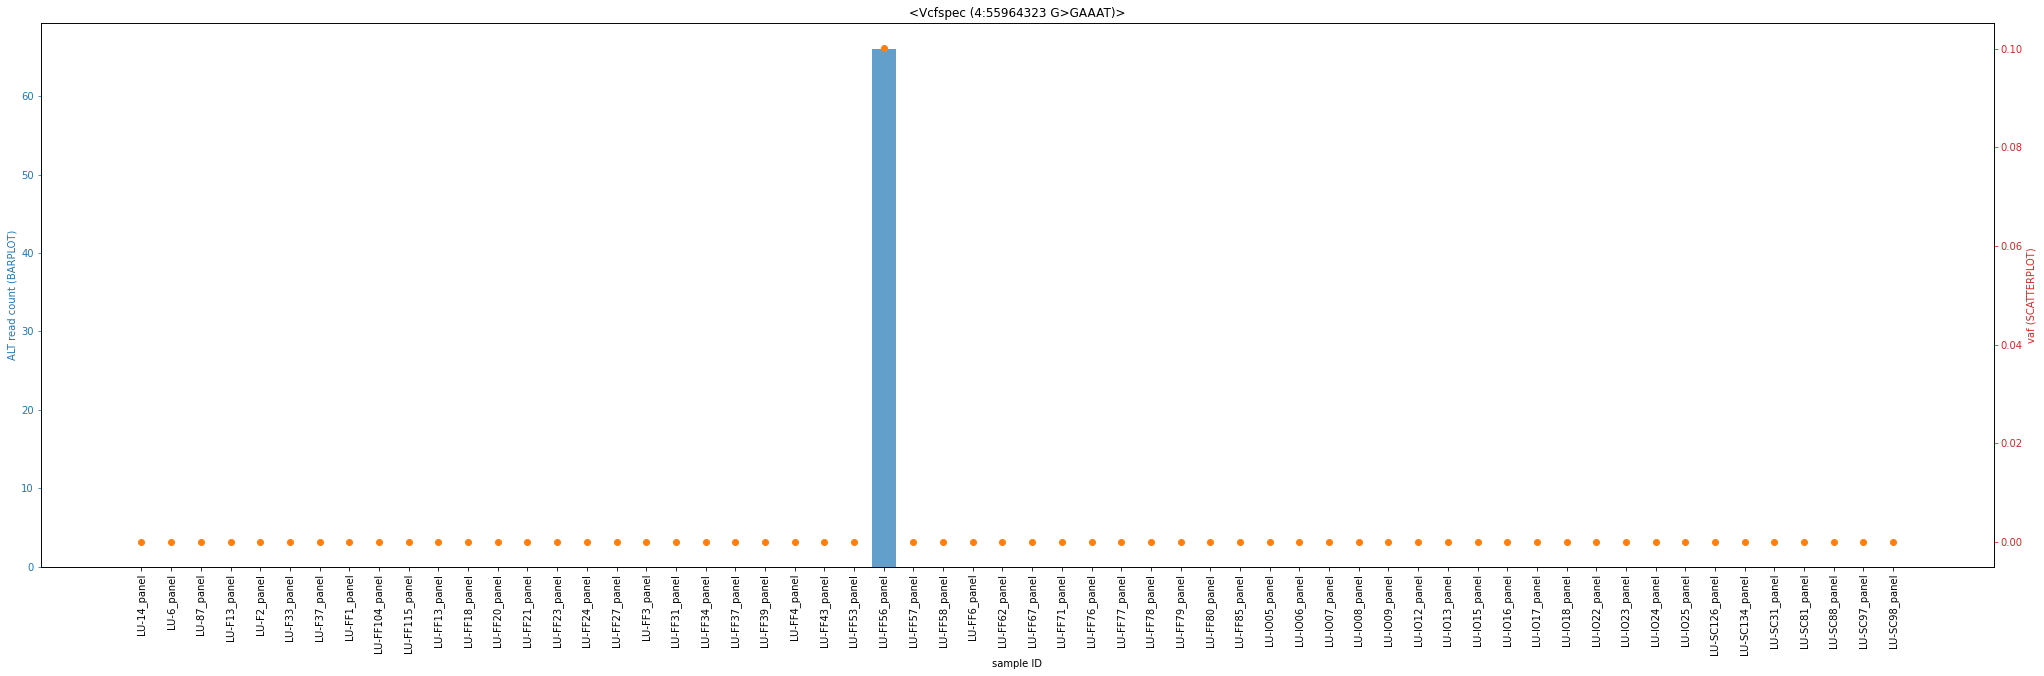

In [572]:
vp.show_readcounts(sampleids=SAMPLEIDS_LU_PANEL, figsize=(35, 10), mask=mask_pon)
# vp.show_readcounts(sampleids=SAMPLEIDS_LU_PANEL, figsize=(35, 10), mask=mask_all)

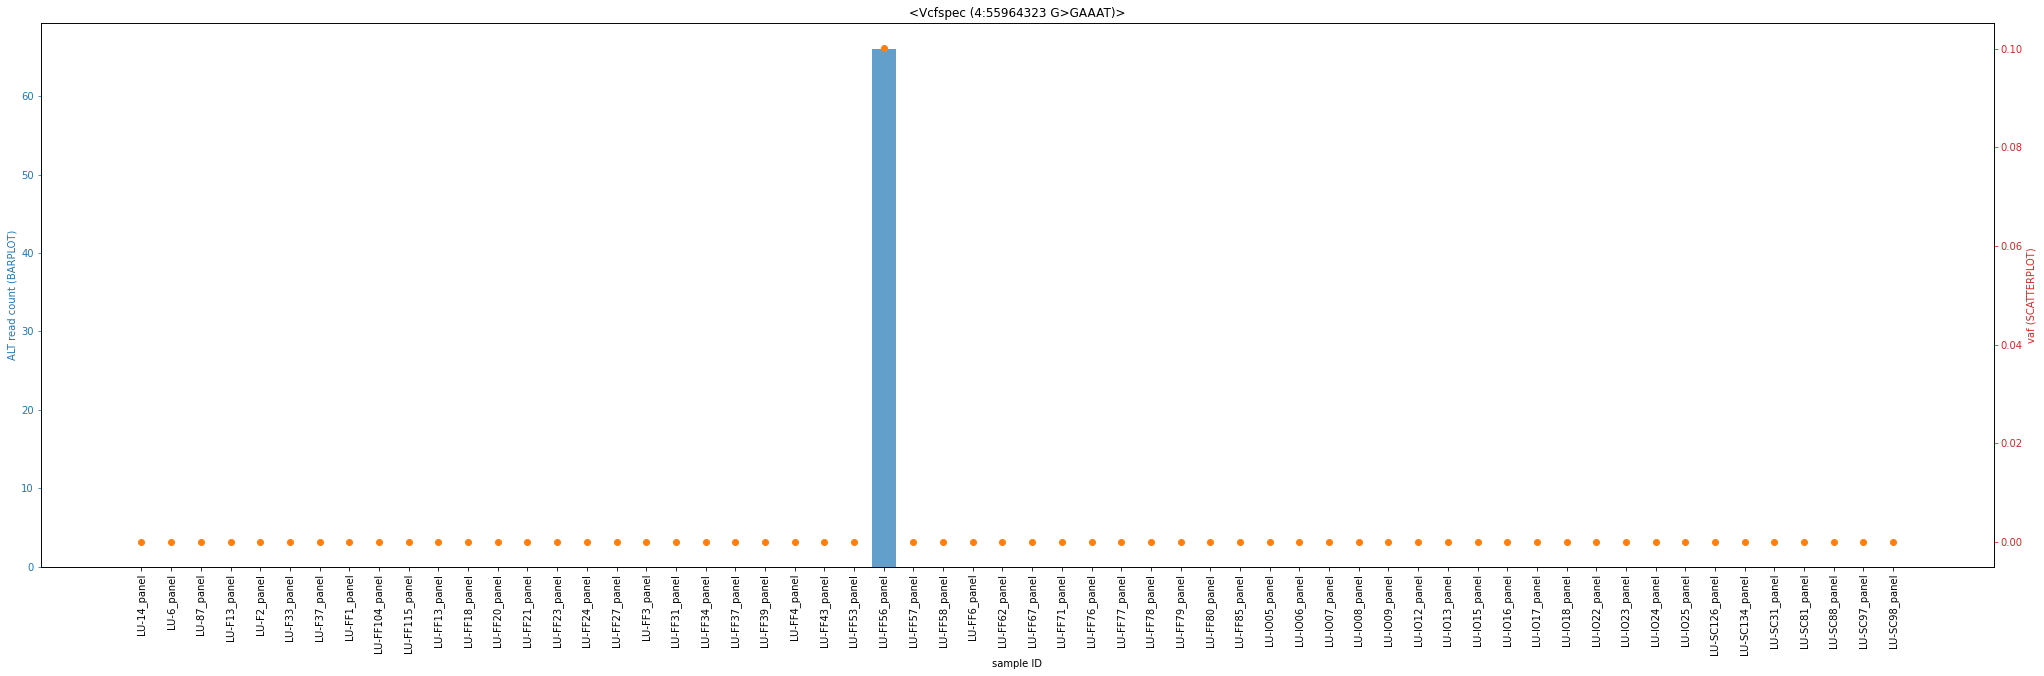

In [573]:
# vp.show_readcounts(sampleids=SAMPLEIDS_LU_PANEL, figsize=(35, 10), mask=mask_pon)
vp.show_readcounts(sampleids=SAMPLEIDS_LU_PANEL, figsize=(35, 10), mask=mask_all)

In [574]:
sampleid = 'LU-FF56'
sampleid_panel = sampleid + '_panel'

In [575]:
show_vp_igv(vp, sampleid)

OK
OK
OK
OK
OK
OK
OK
OK
OK
OK


In [567]:
mask_all = allfilter(vp, sampleid_panel)
print(mask_all)

False


In [568]:
show_filter_results(vp, sampleid_panel)

True    <PopfreqFilter ({'popnames': ('GnomAD', '1000Genomes', 'KOREAN', 'Korea1K'), 'cutoff': 0.01})>
True    <DiffMeanBQFilter ({'cutoff': -5})>
True    <AbsMeanBQFilter ({'cutoff': 20})>
True    <DiffMeanMQFilter ({'cutoff': -15})>
True    <AbsMeanMQFilter ({'cutoff': 40})>
False    <ClipoverlapFilter ({'cutoff': 1})>
True    <ReadcountFilter ({'cutoff': 2})>
False    <OthercountRatioFilter ({'cutoff': 1.5})>


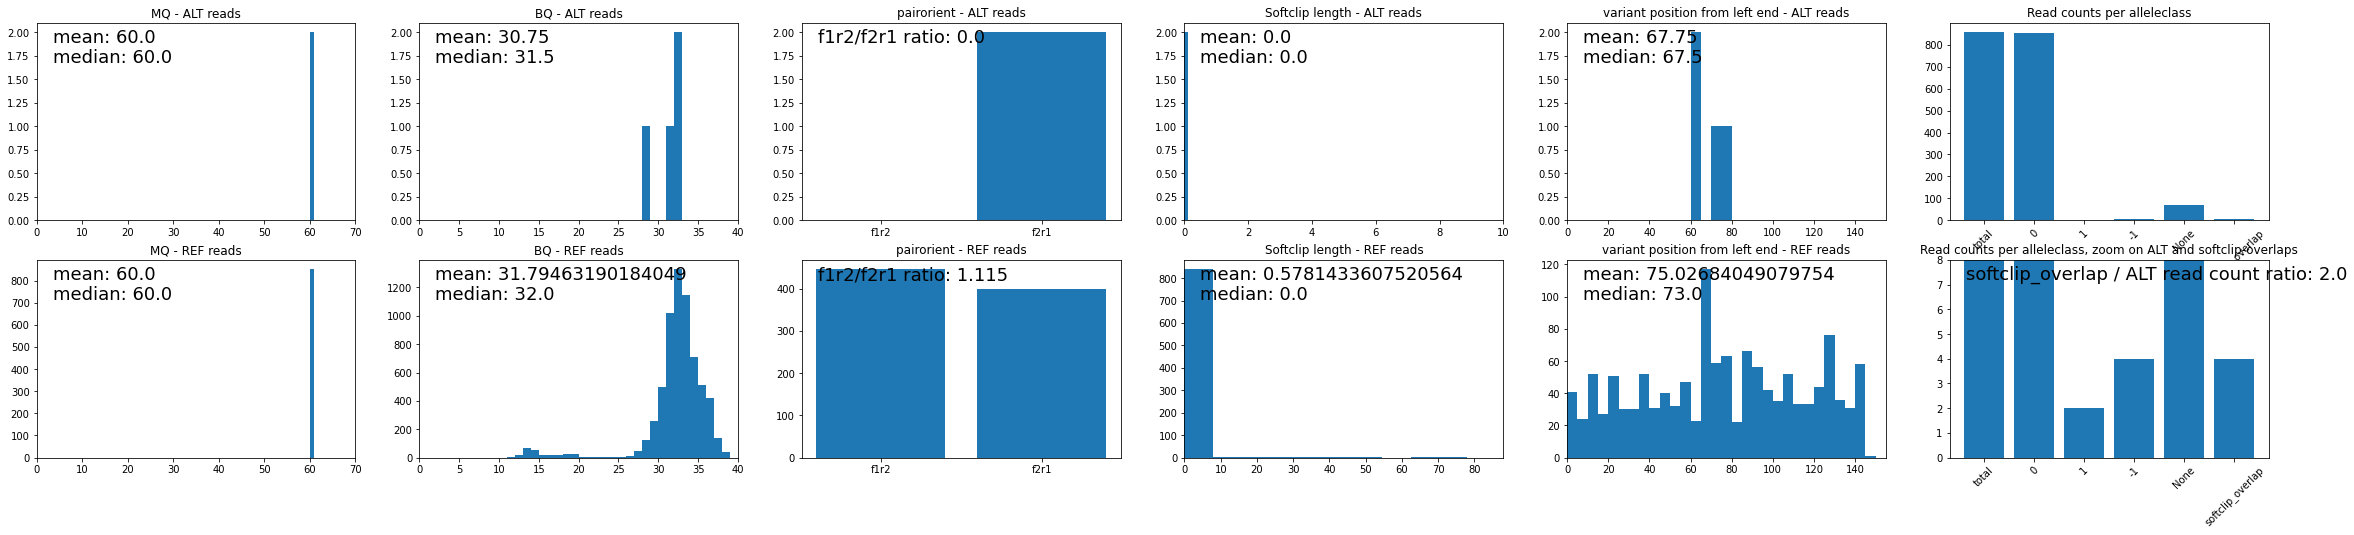

In [569]:
vp.show_readstats_data(bam=BAMS['panel'][sampleid])

In [501]:
rpplist = vp.make_rpplist(bam=BAMS['panel']['LU-IO23'], no_matesearch=True, set_alleleinfo=True)

In [504]:
for rpp in rpplist:
    if rpp.alleleinfo[vp.vcfspec]['alleleclass'] == -1:
        print(rpp.query_name)

NDX550168:98:HGVJLBGXC:3:21402:17456:8932
NDX550168:98:HGVJLBGXC:2:13111:23617:2294
NDX550168:98:HGVJLBGXC:3:12404:20582:9660
NDX550168:98:HGVJLBGXC:1:11307:2269:4321
NDX550168:98:HGVJLBGXC:3:12512:26272:19532
NDX550168:98:HGVJLBGXC:4:23404:25398:6048
NDX550168:98:HGVJLBGXC:2:23103:12644:18847
NDX550168:98:HGVJLBGXC:3:13608:20515:8310
NDX550168:98:HGVJLBGXC:4:13505:23279:11584
NDX550168:98:HGVJLBGXC:4:21409:17769:1988
NDX550168:98:HGVJLBGXC:1:12210:22216:8445
NDX550168:98:HGVJLBGXC:4:22402:6808:16056
NDX550168:98:HGVJLBGXC:4:23601:4266:9061
NDX550168:98:HGVJLBGXC:1:13201:16836:3295
NDX550168:98:HGVJLBGXC:1:11101:1140:14189
NDX550168:98:HGVJLBGXC:3:22407:1383:17904
NDX550168:98:HGVJLBGXC:1:13202:13810:9102
NDX550168:98:HGVJLBGXC:2:21203:18058:14737
NDX550168:98:HGVJLBGXC:4:22504:3820:14527
NDX550168:98:HGVJLBGXC:4:23412:11075:18035
NDX550168:98:HGVJLBGXC:2:12311:24982:1976
NDX550168:98:HGVJLBGXC:3:23604:5955:20240
NDX550168:98:HGVJLBGXC:4:12507:1991:2916
NDX550168:98:HGVJLBGXC:3:22402:2

# SNV analysis

### Load previous wgs vcf VAFs

In [4225]:
wgs_vafs = dict()
wgs_vcfspecs = dict()

for sampleid, vcf_path in PREVIOUS_VCF_PATHS.items():
    vaf_list = list()
    vcfspec_list = list()
    for linedict in sypark_vcf_iterator(vcf_path):
        chrom = linedict['CHROM']
        pos = int(linedict['POS'])
        ref = linedict['REF']
        alt = linedict['ALT']
        ref_read = int(linedict['ref_readN'])
        alt_read = int(linedict['var_readN'])
        
        # vaf
        total_read = ref_read + alt_read
        if total_read == 0:
            vaf = np.nan
        else:
            vaf = alt_read / total_read
        vaf_list.append(vaf)
        
        # vcfspec
        vcfspec = Vcfspec(chrom, pos, ref, (alt,))
        vcfspec_list.append(vcfspec)
        
    vaf_array = np.array(vaf_list)
    
    wgs_vafs[sampleid] = vaf_array
    wgs_vcfspecs[sampleid] = vcfspec_list

### Load previous wgs vcf Vcfspecs

In [ ]:
wgs_vcfspecs = dict()

### Previous wgs TMB data

In [29]:
wgs_tmb_df = pd.read_csv(WGS_TMB_PATH, sep='\t', index_col=0) 

wgs_snv_counts = dict()
for idx in wgs_tmb_df.index:
    wgs_snv_counts[idx] = wgs_tmb_df.loc[idx][0]

### Union-ed panel vcf path

In [23]:
PANEL_VCF_PATH = '/home/users/team_projects/Lung_Cancer_Panel_data/03_Data_from_YTKim/09_short_variants_union/220531/04_panel_union_all/panel_union.annot.readstats_wgs.vcf.gz'

### Filter by panel bait region

In [21]:
for vcfp in vcfp_dict.values():
    vcfp.filter_isec(PANEL_REGION_GR)

In [47]:
outdir = '/home/users/team_projects/Lung_Cancer_Panel_data/03_Data_from_YTKim/09_short_variants_union/220531/03_panel_filter_panelregion/'
for sampleid, vcfp in vcfp_dict.items():
    print(sampleid)
    outfile_path = os.path.join(outdir, f'{sampleid}.vcf.gz')
    vcfp.write(outfile_path, vcfp.vplist_filtered)

14
6
87
F13
F2
F33
F37
FF1
FF104
FF115
FF13
FF18
FF20
FF21
FF23
FF24
FF27
FF3
FF31
FF34
FF37
FF39
FF4
FF43
FF53
FF56
FF57
FF58
FF6
FF62
FF67
FF71
FF76
FF77
FF78
FF79
FF80
FF85
IO04
IO05
IO06
IO07
IO08
IO09
IO12
IO13
IO15
IO16
IO17
IO18
IO22
IO23
IO24
IO25
SC126
SC134
SC31
SC81
SC88
SC97
SC98


### Load VcfPlus

In [24]:
vcfp = VcfPlus(PANEL_VCF_PATH, set_annotdb=True, set_readstats=True, logging_lineno=1000)

[KST 2022-07-06 14:19:54 INFO] panel_union.annot.readstats_wgs.vcf.gz: 1000 variant records processed
[KST 2022-07-06 14:20:13 INFO] panel_union.annot.readstats_wgs.vcf.gz: 2000 variant records processed
[KST 2022-07-06 14:20:33 INFO] panel_union.annot.readstats_wgs.vcf.gz: 3000 variant records processed
[KST 2022-07-06 14:20:52 INFO] panel_union.annot.readstats_wgs.vcf.gz: 4000 variant records processed
[KST 2022-07-06 14:21:11 INFO] panel_union.annot.readstats_wgs.vcf.gz: 5000 variant records processed


### Sample swap test - normal wgs germline variants check

In [4139]:
sampleid = SAMPLEIDS_LU[61]
print(sampleid)

def check_between(val, limits):
    return (val > limits[0] and val < limits[1])

width = 0.3
limits = (0.5 - width, 0.5 + width)

vplist_normal_germlines = [vp for vp in vcfp.vplist if 
                           (vp.get_vaf(f'{sampleid}_normal') is not None and
                            check_between(vp.get_vaf(f'{sampleid}_normal'), limits))]
print(len(vplist_normal_germlines))

IndexError: list index out of range

In [4074]:
vplist_sampled = random.sample(vplist_normal_germlines, 30)
# vplist_sampled = vplist_normal_germlines

In [4075]:
idx = -1

In [4137]:
idx += 1
print(f'idx = {idx}')

idx = 30


In [4138]:
sampleid_igvshow = sampleid
# sampleid_igvshow = SAMPLEIDS_LU[59]

print(idx)
vp = vplist_sampled[idx]
show_vp_igv(vp, sampleid_igvshow)
# igv.cmd('sort start')

30


IndexError: list index out of range

### Apply sample-wise filters

In [32]:
def get_samplewise_filter_mask(vp, pon_n_sample=5, pon_ratio=5, pon_minsubset_fraction=0.5, pon_mode='mean',
                               popfreq_cutoff=0.01,
                               bq_diff=-10, mq_diff=-15, refmq_cutoff=40, 
                               clipoverlap_ratio=1, altcount_cutoff=3, othercount_ratio=2):
    ponfilter_result = pon_filter(vp, 
                                  n_sample_cutoff=pon_n_sample, 
                                  ratio_cutoff=pon_ratio, 
                                  minsubset_fraction=pon_minsubset_fraction, 
                                  mode=pon_mode)
    popfreq_filter_result = popfreq_filter(vp, cutoff=popfreq_cutoff)
    bqfilter_result = BQ_filter(vp, diff_cutoff=bq_diff)
    mqfilter_result = MQ_filter(vp, diff_cutoff=mq_diff)
    mqfilter_ref_result = MQ_filter_REF(vp, cutoff=refmq_cutoff)
    clipovlpfilter_result = clipoverlap_filter(vp, ratio_cutoff=clipoverlap_ratio)
    altcountfilter_result = altcount_filter(vp, cutoff=altcount_cutoff)
    othercountfilter_result = othercount_filter(vp, ratio_cutoff=othercount_ratio)

    mask = functools.reduce(np.logical_and, [ponfilter_result['mask'], 
                                             popfreq_filter_result['mask'],
                                             bqfilter_result['mask'], 
                                             mqfilter_result['mask'], 
                                             mqfilter_ref_result['mask'],
                                             clipovlpfilter_result['mask'], 
                                             altcountfilter_result['mask'],
                                             othercountfilter_result['mask'],
                                             ])
    
    return mask

def apply_mask(vp, mask):
    for maskitem, sampleid in zip(mask, SAMPLEIDS_LU):
        if maskitem:
            vp.add_sample_filter(sampleid, 'PASS')
            
def apply_samplewise_filter(vp, **kwargs):
    mask = get_samplewise_filter_mask(vp, **kwargs)
    apply_mask(vp, mask)

In [4193]:
# pon_minsubset_fraction = 0.5
# pon_ratio = 5
pon_minsubset_fraction = 0.8
pon_ratio = 15

for vp in vcfp.vplist:
    vp.reset_sample_filter_all()
    apply_samplewise_filter(vp, clipoverlap_ratio=3, 
                            popfreq_cutoff=0.01, 
                            pon_ratio=pon_ratio, 
                            pon_minsubset_fraction=pon_minsubset_fraction)

### Get filtered variant lists for each sample

In [4194]:
filtered_vplists = dict((sampleid, VariantPlusList()) for sampleid in SAMPLEIDS_LU)
for vp in vcfp.vplist:
    for sampleid in filtered_vplists.keys():
        if vp.check_sample_filter(sampleid):
            filtered_vplists[sampleid].append(vp)

In [4195]:
for sid, vplist in filtered_vplists.items():
    print(sid, len(vplist), sep=(' ' * 5))

LU-14     6
LU-6     2
LU-87     12
LU-F13     3
LU-F2     2
LU-F33     4
LU-F37     10
LU-FF1     22
LU-FF104     2
LU-FF115     1
LU-FF13     8
LU-FF18     26
LU-FF20     5
LU-FF21     4
LU-FF23     6
LU-FF24     8
LU-FF27     1
LU-FF3     5
LU-FF31     5
LU-FF34     7
LU-FF37     2
LU-FF39     6
LU-FF4     9
LU-FF43     3
LU-FF53     105
LU-FF56     12
LU-FF57     11
LU-FF58     6
LU-FF6     1
LU-FF62     90
LU-FF67     3
LU-FF71     3
LU-FF76     0
LU-FF77     3
LU-FF78     3
LU-FF79     14
LU-FF80     29
LU-FF85     32
LU-IO04     41
LU-IO05     10
LU-IO06     10
LU-IO07     115
LU-IO08     2
LU-IO09     30
LU-IO12     22
LU-IO13     24
LU-IO15     10
LU-IO16     26
LU-IO17     35
LU-IO18     8
LU-IO22     36
LU-IO23     13
LU-IO24     10
LU-IO25     22
LU-SC126     7
LU-SC134     7
LU-SC31     12
LU-SC81     7
LU-SC88     30
LU-SC97     3
LU-SC98     4


### Plot vaf distributions

(array([ 12., 182., 359., 382., 366., 377., 439., 415., 342., 282., 208.,
        171., 108.,  72.,  41.,  25.,  26.,  24.,  16.,   6.]),
 array([0.02302632, 0.06610577, 0.10918522, 0.15226468, 0.19534413,
        0.23842358, 0.28150304, 0.32458249, 0.36766194, 0.4107414 ,
        0.45382085, 0.4969003 , 0.53997976, 0.58305921, 0.62613866,
        0.66921812, 0.71229757, 0.75537702, 0.79845648, 0.84153593,
        0.88461538]),
 <BarContainer object of 20 artists>)

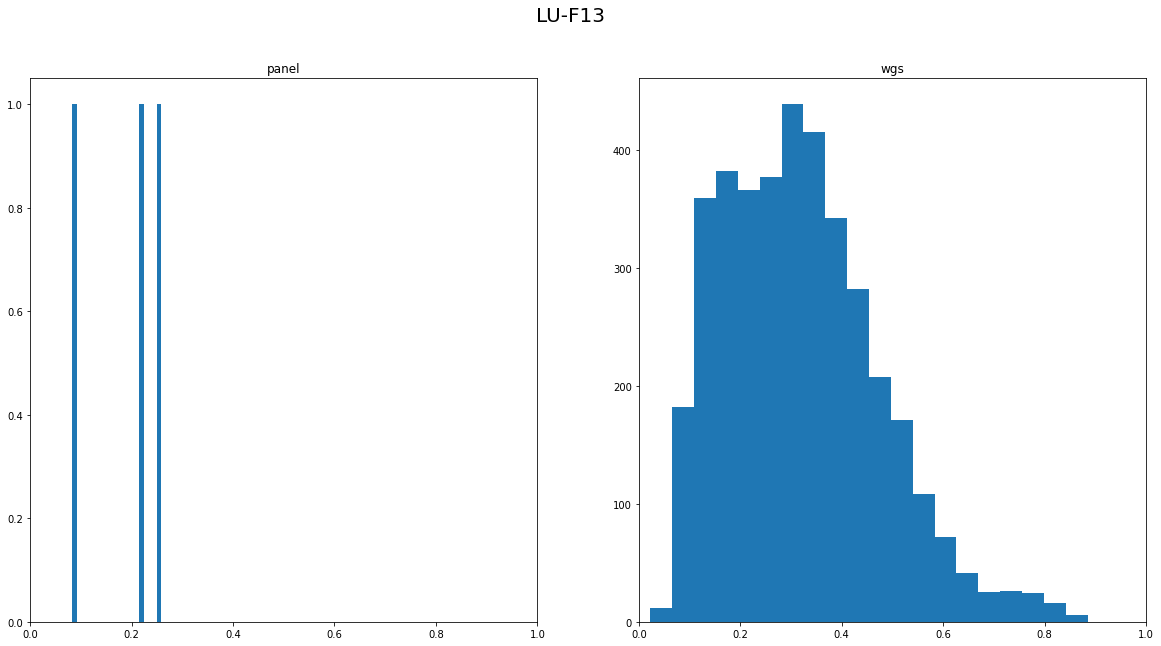

In [4224]:
%matplotlib inline

# data setup
sampleid = 'LU-F13'
vafs_panel = np.array([vp.get_vaf(sampleid) for vp in filtered_vplists[sampleid]])
vafs_wgs = wgs_vafs[sampleid]
bins = 20

# plotting
fig, axs = plt.subplots(1, 2, figsize=(20, 10), subplot_kw={'xlim': (0, 1)})
fig.suptitle(sampleid, size=20)

axs[0].set_title('panel')
axs[0].hist(vafs_panel, bins=bins)

axs[1].set_title('wgs')
axs[1].hist(vafs_wgs, bins=bins)

In [45]:
vplist_driver

[<VariantPlus object (7	55241708	.	G	C)>,
 <VariantPlus object (7	55247466	.	G	A)>,
 <VariantPlus object (7	55249005	.	G	T)>,
 <VariantPlus object (7	55278584	.	G	C)>]

OK
OK
OK
OK
OK
OK
OK
OK
OK
OK


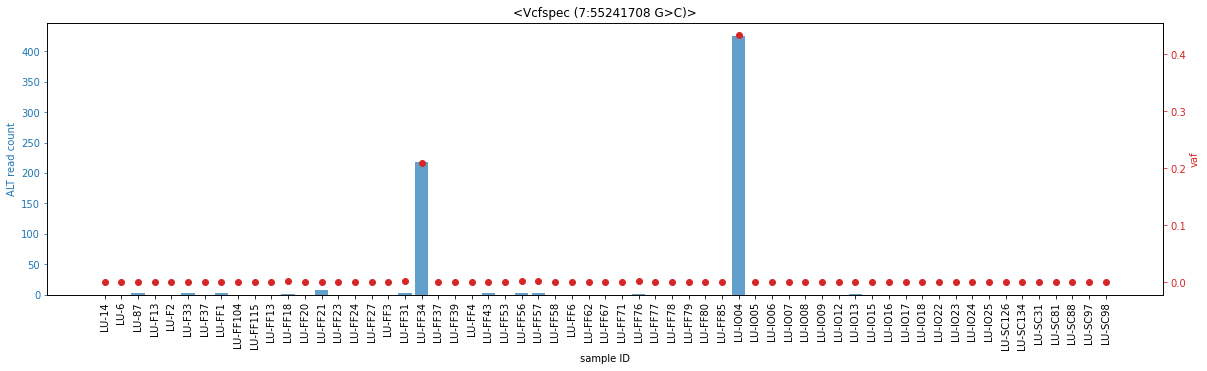

In [46]:
# vp = vplist.sample()
vp = vplist_driver[0]

show_vp_igv(vp, sampleid)
show_vp_altcounts(vp)

In [54]:
# vp_test = VariantPlus(vcfspec=Vcfspec('7', 55_241_707, 'G', ('A',)), refver='hg19')
vp_test = VariantPlus(vcfspec=Vcfspec('7', 55_241_678, 'A', ('C',)), refver='hg19')
vp_test.annotdb.update_features_ensembl_wrapper_plain(vcfspec=vp_test.vcfspec, vep=True)

In [55]:
vp_test.annotdb.transcript_canon_ovlp

{'ENST00000275493': {'aa_change': ['E', 'A'],
                     'biotype': 'protein_coding',
                     'cadd_phred': 28.2,
                     'cadd_raw': 4.060248,
                     'ccds_id': 'CCDS5514.1',
                     'codon_change': ['gAa', 'gCa'],
                     'consequence_flags': {'is_3pUTR_involved': False,
                                           'is_5pUTR_involved': False,
                                           'is_SV_consequence': False,
                                           'is_frameshift': False,
                                           'is_missense': True,
                                           'is_not_protein_altering': False,
                                           'is_protein_altering': True,
                                           'is_splice_acceptor_involved': False,
                                           'is_splice_donor_involved': False,
                                           'is_splice_region_involved

### Plot signatures

In [4231]:
panel_vcfspecs = dict()
for sampleid, vplist in filtered_vplists.items():
    panel_vcfspecs[sampleid] = [vp.vcfspec for vp in vplist]

In [4251]:
from handygenome.signature.signatureresult import get_sigresult_from_vcfspecs

sampleid = 'LU-IO17'

sigresult_panel = get_sigresult_from_vcfspecs(panel_vcfspecs[sampleid], refver='GRCh37')
sigresult_wgs = get_sigresult_from_vcfspecs(wgs_vcfspecs[sampleid], refver='GRCh37')

[KST 2022-06-24 13:55:01 INFO] handygenome.signature.signatureresult: Creating mutation catalogue
[KST 2022-06-24 13:55:01 INFO] handygenome.signature.signatureresult: Running SigProfilerAssignment
[KST 2022-06-24 13:55:01 INFO] handygenome.signature.signatureresult: All finished.
[KST 2022-06-24 13:55:01 INFO] handygenome.signature.signatureresult: Creating mutation catalogue
[KST 2022-06-24 13:55:04 INFO] handygenome.signature.signatureresult: Running SigProfilerAssignment
[KST 2022-06-24 13:55:04 INFO] handygenome.signature.signatureresult: All finished.


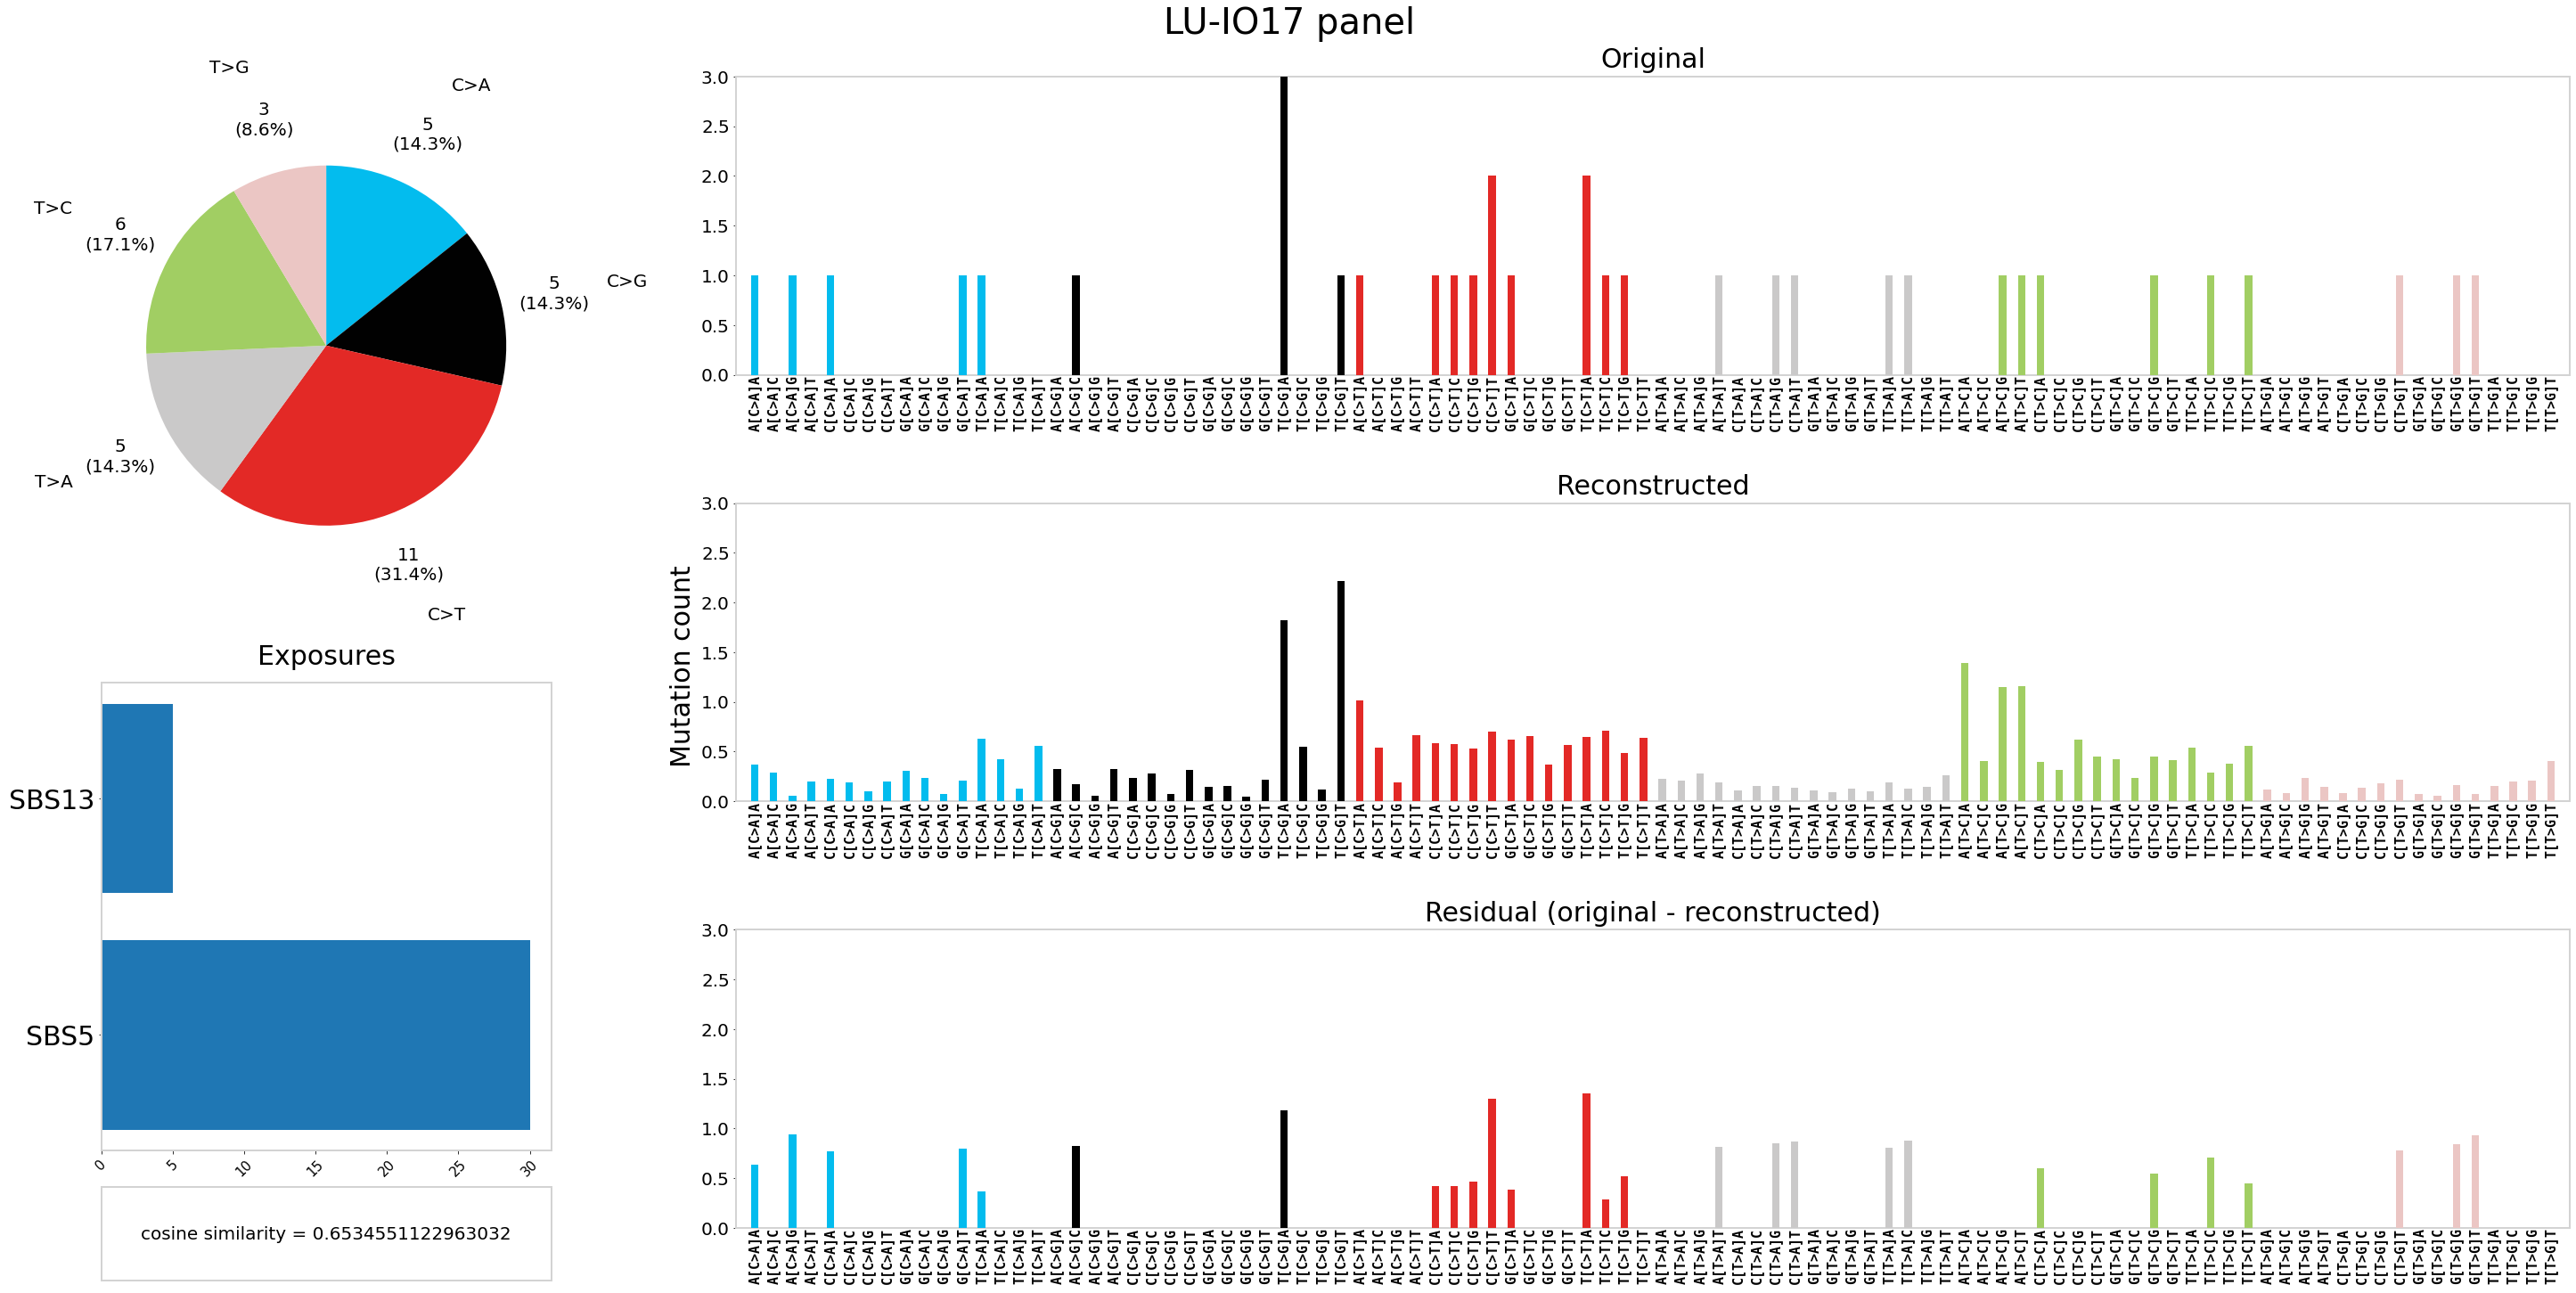

In [4252]:
sigresult_panel.plot(sampleid + ' panel')

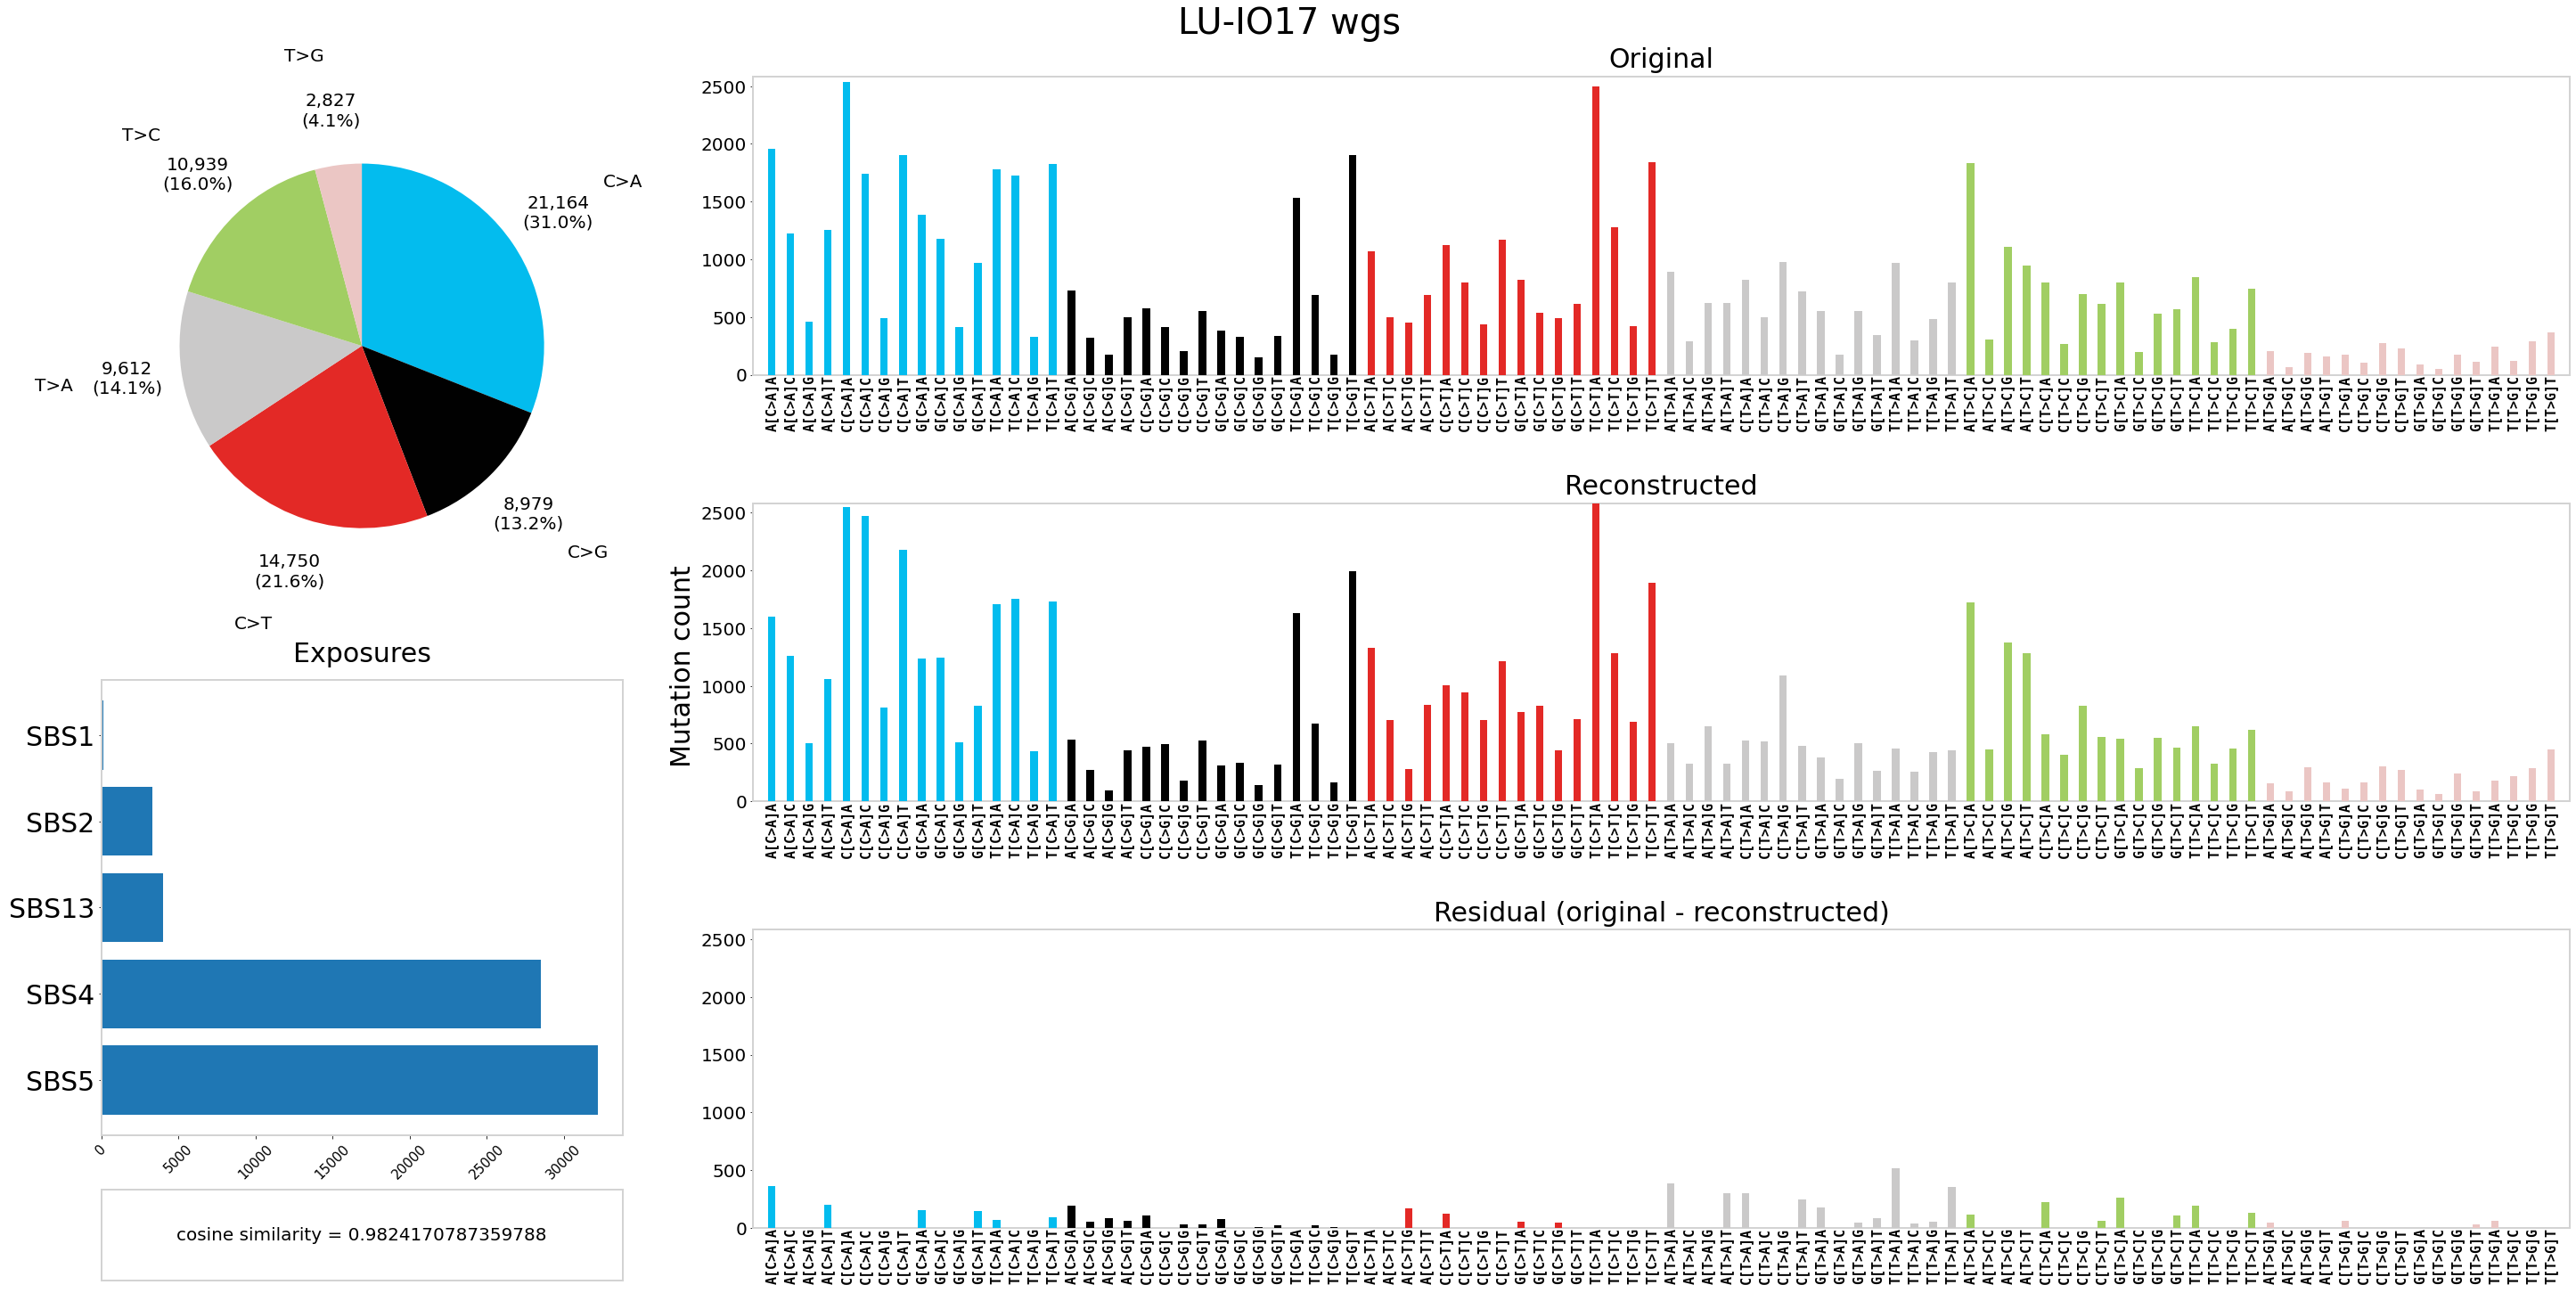

In [4253]:
sigresult_wgs.plot(sampleid + ' wgs')

<Vcfspec (1:3130443 C>T)>

### Plot snv counts

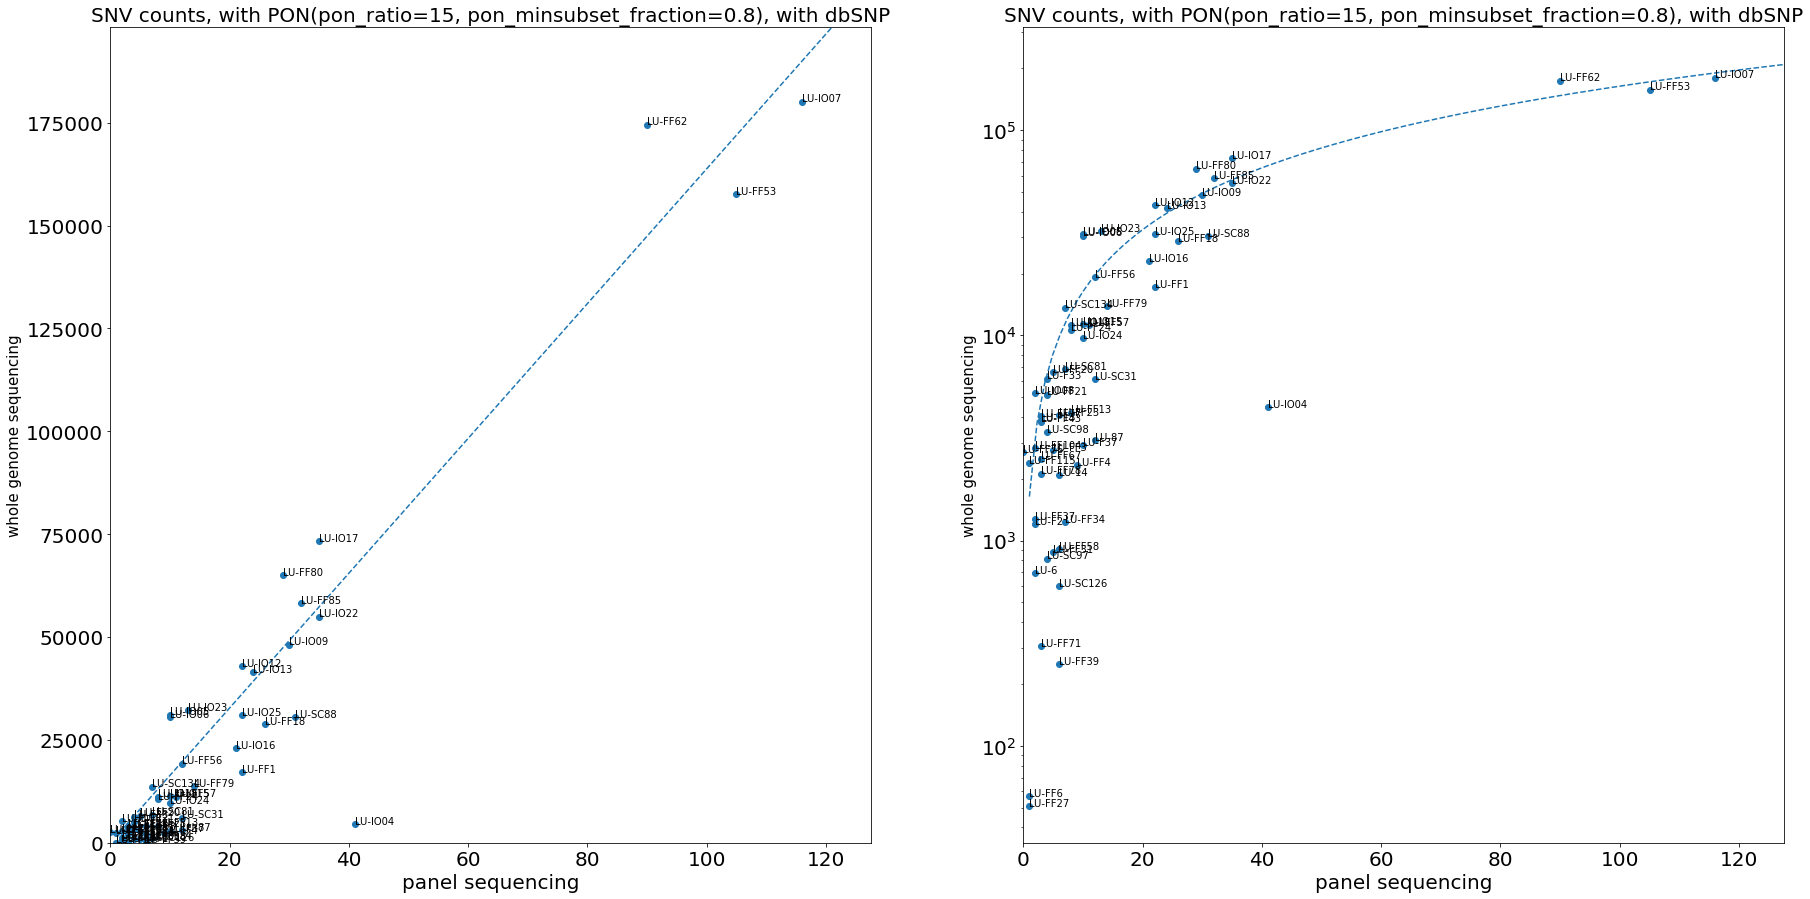

In [43]:
%matplotlib inline

snv_counts_panel = {sampleid: len(vplist) 
                    for sampleid, vplist in filtered_vplists.items()}
x = [snv_counts_panel[sampleid] for sampleid in SAMPLEIDS_LU]
y = [snv_counts_wgs[sampleid] for sampleid in SAMPLEIDS_LU]
labels = SAMPLEIDS_LU

def plotter_snv_tmb(ax, x, y, labels, pon_ratio, pon_minsubset_fraction, logscale=False):
    # labels
    # ax.set_title('SNV counts, without PON, without dbSNP', fontsize=20)
    ax.set_title(
        f'SNV counts, with PON(pon_ratio={pon_ratio}, '
        f'pon_minsubset_fraction={pon_minsubset_fraction}), with dbSNP', 
        fontsize=20)
    # ax.set_title('SNV counts, without PON, with dbSNP', fontsize=20)
    ax.set_xlabel('panel sequencing', fontsize=20)
    ax.set_ylabel('whole genome sequencing', fontsize=15)
    ax.tick_params('x', labelsize=20)
    ax.tick_params('y', labelsize=20)

    # xlim, ylim
    ax.set_xlim(0, max(x) * 1.1)
    # ax.set_xlim(0, 20)
    if not logscale:
        ax.set_ylim(0, max(y) * 1.1)
    # ax.set_ylim(0, 50000)

    # logscale y
    if logscale:
        ax.set_yscale('log')

    # scatterplot
    ax.scatter(x, y)

    # text annotation
    for idx, text in enumerate(labels):
        ax.annotate(text, (x[idx], y[idx]), fontsize=10)

    # abline
    ax_xlim_min, ax_xlim_max = ax.get_xlim()
    if ax_xlim_min == 0:
        ax_xlim_min = 1
    line_xvals = np.linspace(ax_xlim_min, ax_xlim_max, 100)
    line_yvals = 1638 * line_xvals
    ax.plot(line_xvals, line_yvals, '--')

    
fig, axs = plt.subplots(1, 2, figsize=(30, 15))
plotter_snv_tmb(axs[0], x, y, labels, pon_ratio, pon_minsubset_fraction, logscale=False)
plotter_snv_tmb(axs[1], x, y, labels, pon_ratio, pon_minsubset_fraction, logscale=True)

### Plot TMB

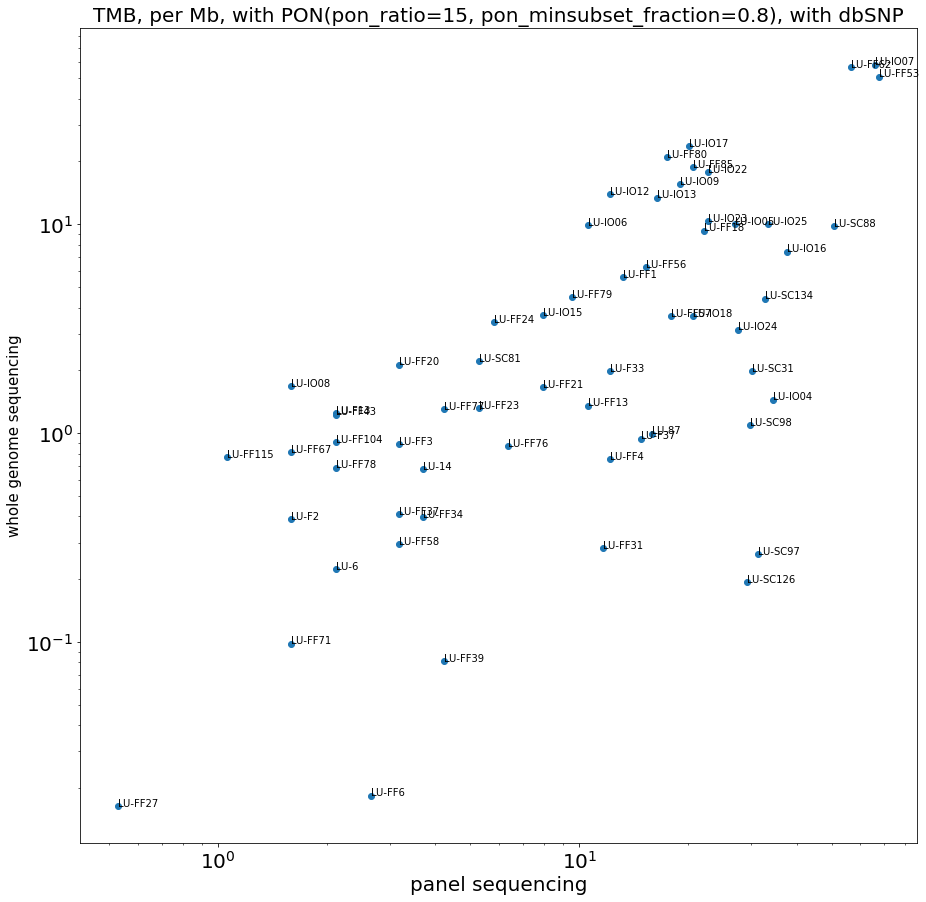

In [594]:
x = [1e6 * snv_counts_panel[sampleid] / PANEL_REGION_LENGTH for sampleid in SAMPLEIDS_LU]
y = [1e6 * snv_counts_wgs[sampleid] / WHOLE_GENOME_LENGTH for sampleid in SAMPLEIDS_LU]
labels = SAMPLEIDS_LU

fig, ax = plt.subplots(figsize=(15, 15))
logscale = False

# labels
# ax.set_title('SNV counts, without PON, without dbSNP', fontsize=20)
ax.set_title(f'TMB, per Mb, with PON(pon_ratio={pon_ratio}, pon_minsubset_fraction={pon_minsubset_fraction}), with dbSNP', fontsize=20)
# ax.set_title('SNV counts, without PON, with dbSNP', fontsize=20)
ax.set_xlabel('panel sequencing', fontsize=20)
ax.set_ylabel('whole genome sequencing', fontsize=15)
ax.tick_params('x', labelsize=20)
ax.tick_params('y', labelsize=20)

# xlim, ylim
# ax.set_xlim(0, max(x) * 1.1)
# ax.set_xlim(0, 20)
# if not logscale:
#     ax.set_ylim(0, max(y) * 1.1)
# ax.set_ylim(0, 50000)

# logscale
ax.set_xscale('log')
ax.set_yscale('log')

# scatterplot
ax.scatter(x, y)

# text annotation
for idx, text in enumerate(labels):
    ax.annotate(text, (x[idx], y[idx]), fontsize=10)

In [493]:
show_vp_igv(vp, sampleid)

OK
OK
OK
OK
OK
OK
OK
OK
OK
OK


### Load panel vcf VAFs

In [92]:
panel_vafs = dict()
for sampleid, vplist in filtered_vplists.items():
    vafarray = np.array([vp.get_vaf(sampleid) for vp in vplist])
    panel_vafs[sampleid] = vafarray

### Draw VAF scatterplot

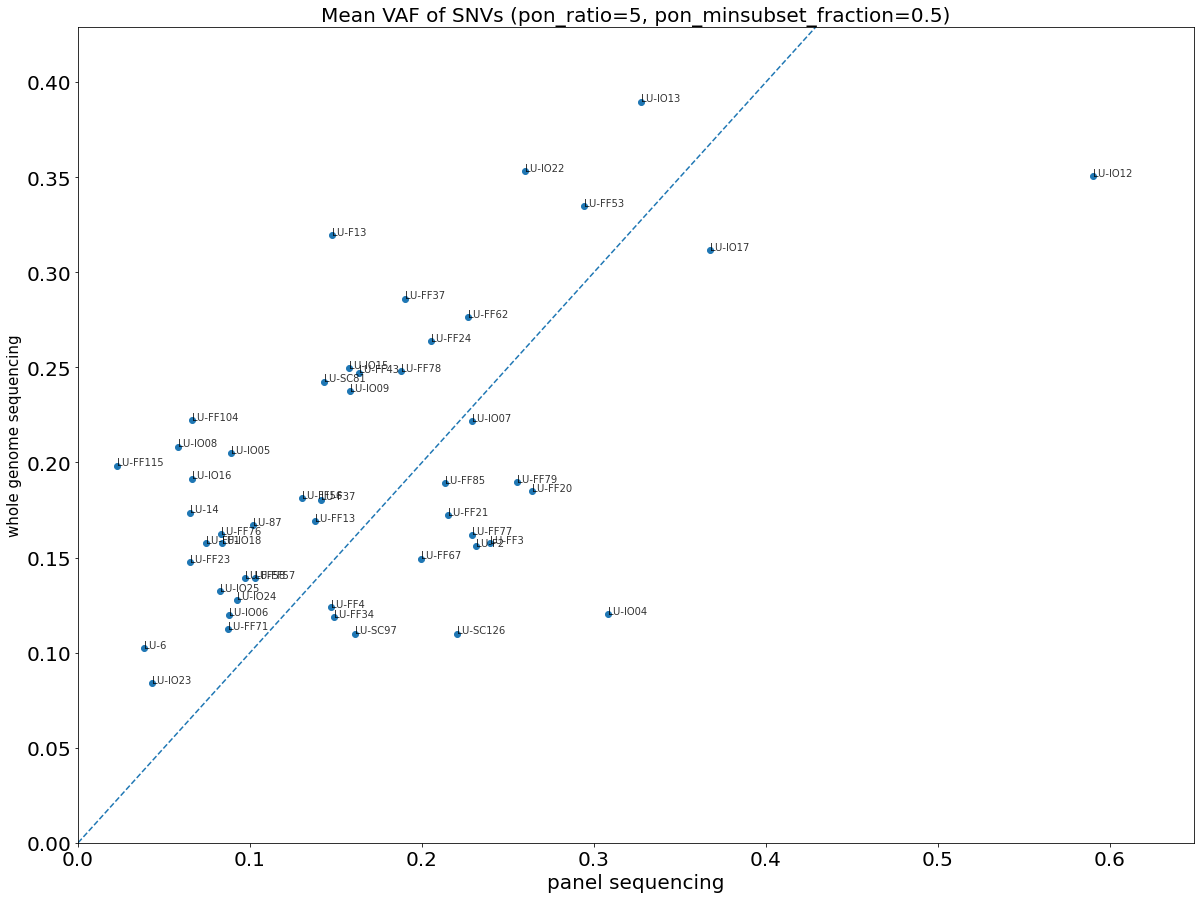

In [559]:
previous_sampleids = [x for x in SAMPLEIDS_LU if x in previous_wgs_vafs]
x = [np.mean(panel_vafs[sampleid]) for sampleid in previous_sampleids]
y = [np.mean(previous_wgs_vafs[sampleid]) for sampleid in previous_sampleids]
labels = previous_sampleids

logscale = False

fig, ax = plt.subplots(figsize=(20, 15))

# labels
ax.set_title(f'Mean VAF of SNVs (pon_ratio={pon_ratio}, pon_minsubset_fraction={pon_minsubset_fraction})', fontsize=20)
ax.set_xlabel('panel sequencing', fontsize=20)
ax.set_ylabel('whole genome sequencing', fontsize=15)
ax.tick_params('x', labelsize=20)
ax.tick_params('y', labelsize=20)

# xlim, ylim
ax.set_xlim(0, max(x) * 1.1)
# ax.set_xlim(0, 20)
if not logscale:
    ax.set_ylim(0, max(y) * 1.1)
# ax.set_ylim(0, 50000)

# logscale y
if logscale:
    ax.set_yscale('log')

# scatterplot
ax.scatter(x, y)

# text annotation
for idx, text in enumerate(labels):
    ax.annotate(text, (x[idx], y[idx]), fontsize=10, alpha=0.8)

# abline
ax_xlim_min, ax_xlim_max = ax.get_xlim()
# if ax_xlim_min == 0:
#     ax_xlim_min = 1
line_xvals = np.linspace(ax_xlim_min, ax_xlim_max, 100)
line_yvals = 1 * line_xvals
ax.plot(line_xvals, line_yvals, '--')


### Filtering

In [28]:
def vpfilter01(vp):
    index_popfreq = max(vp.get_popfreq('GnomAD'), 
                        vp.get_popfreq('1000Genomes'),
                        vp.get_popfreq('KOREAN'),
                        vp.get_popfreq('Korea1K'))
    return index_popfreq < 0.01

def vpfilter02(vp):
    return (vp.get_cosmic_total_occur() > 100)

def vpfilter03(vp):
    alt_counts = get_alt_counts(vp)
    max_alt_count = max(alt_counts)
    return max_alt_count > 1000

def vpfilter04(vp):
    alt_counts = get_alt_counts(vp)
    return any(x in range(50, 100) for x in alt_counts)

def vpfilter05(vp):
    alt_counts = get_alt_counts(vp)
    return max(alt_counts) in range(3, 6)
#     return max(alt_counts) > 5

def vpfilter06(vp):
    return vp.vr.contig == '12' and vp.vr.pos == 25398284

def vpfilter07(vp):
    alt_counts = get_alt_counts(vp)
    n_pon_samples = sum(alt_counts > 0)
    return n_pon_samples < 5

def vpfilter08(vp):
    return vp.check_sample_filter('LU-IO04')

###

def vpfilter(vp):
#     return vpfilter08(vp)
#     return vpfilter01(vp) and vpfilter07(vp) and vpfilter05(vp)
#     return vpfilter06(vp)
#     return vpfilter01(vp)
    return vpfilter01(vp) and vpfilter04(vp)
#     return vpfilter01(vp) and vpfilter02(vp)

vcfp.filter_vplist(vpfilter)
print(len(vcfp.vplist_filtered))

NameError: name 'vcfp' is not defined

### Choose a vp

In [23]:
vp = VariantPlus(vcfspec=Vcfspec('12', 25398284, 'C', ('T',)), refver='hg19')

In [26]:
igv.load([BAM_PATHS['panel']['LU-FF67']])

OK


In [27]:
igv.goto([vp.vcfspec])

OK


In [26]:
# vp_samples = vcfp.vplist_filtered.sample(10)
vp = vcfp.vplist_filtered.sample(1)

In [24]:
bam = pysam.AlignmentFile(bam_path)

{'LU-IO13': '/home/users/team_projects/Lung_Cancer_Panel_data/03_Data_from_YTKim/02_BAM/IO13/LU-IO13.panel.bam',
 'LU-FF79': '/home/users/team_projects/Lung_Cancer_Panel_data/03_Data_from_YTKim/02_BAM/FF79/LU-FF79.panel.bam',
 'LU-SC134': '/home/users/team_projects/Lung_Cancer_Panel_data/03_Data_from_YTKim/02_BAM/SC134/LU-SC134.panel.bam',
 'LU-IO04': '/home/users/team_projects/Lung_Cancer_Panel_data/03_Data_from_YTKim/02_BAM/IO04/LU-IO04.panel.bam',
 'LU-FF104': '/home/users/team_projects/Lung_Cancer_Panel_data/03_Data_from_YTKim/02_BAM/FF104/LU-FF104.panel.bam',
 'LU-FF76': '/home/users/team_projects/Lung_Cancer_Panel_data/03_Data_from_YTKim/02_BAM/FF76/LU-FF76.panel.bam',
 'LU-FF53': '/home/users/team_projects/Lung_Cancer_Panel_data/03_Data_from_YTKim/02_BAM/FF53/LU-FF53.panel.bam',
 'LU-FF6': '/home/users/team_projects/Lung_Cancer_Panel_data/03_Data_from_YTKim/02_BAM/FF6/LU-FF6.panel.bam',
 'LU-FF27': '/home/users/team_projects/Lung_Cancer_Panel_data/03_Data_from_YTKim/02_BAM/FF27/

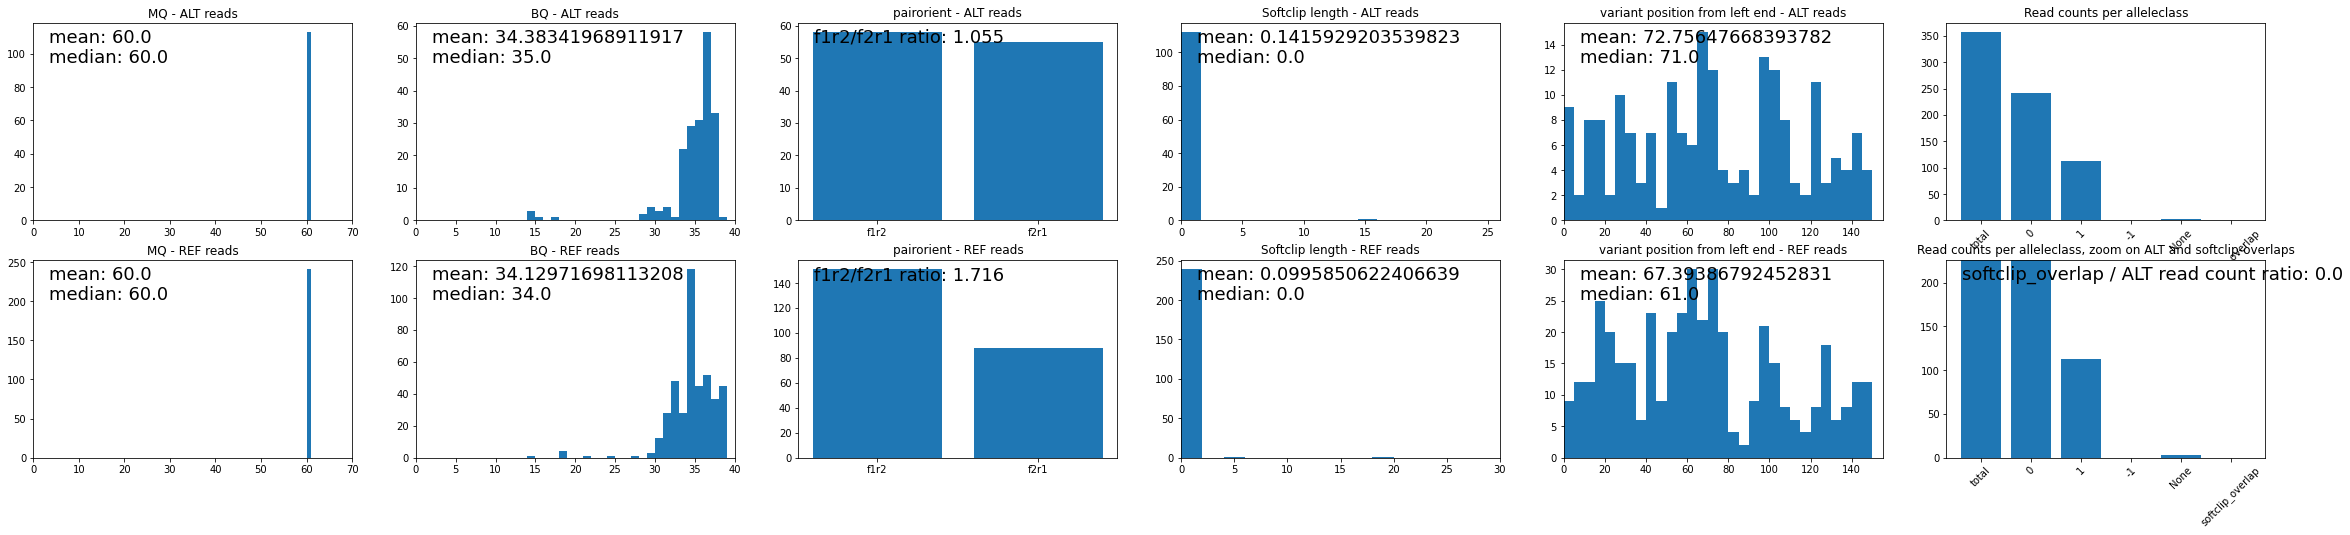

In [22]:
vp.show_readstats_data(bam=BAMS['panel']['LU-FF67'])

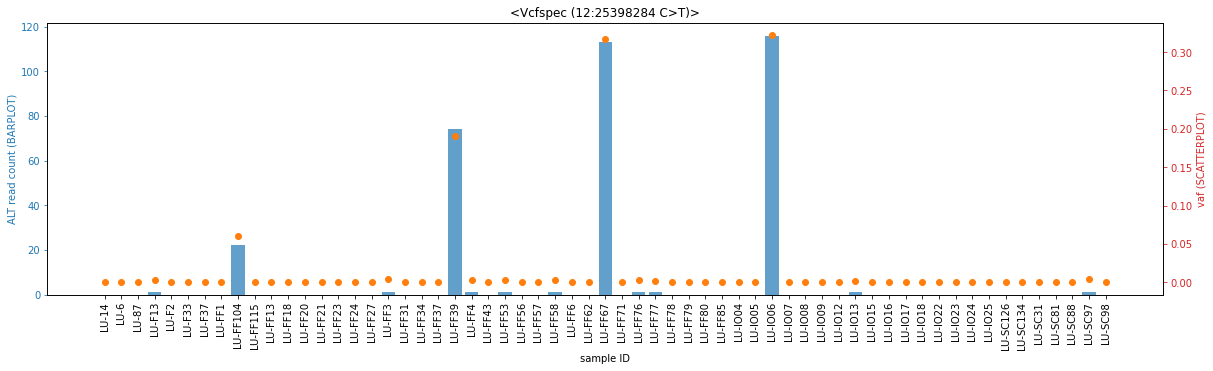

In [34]:
vp.show_pon_altcounts(SAMPLEIDS_LU)

In [64]:
import handygenome.variantplus.vpfilter
ponfilter = handygenome.variantplus.vpfilter.PonFilter(SAMPLEIDS_LU)

In [56]:
vp.show_sample_filters()

LU-14 (None,)
LU-6 (None,)
LU-87 (None,)
LU-F13 (None,)
LU-F2 (None,)
LU-F33 (None,)
LU-F37 (None,)
LU-FF1 (None,)
LU-FF104 (None,)
LU-FF115 (None,)
LU-FF13 (None,)
LU-FF18 (None,)
LU-FF20 (None,)
LU-FF21 (None,)
LU-FF23 (None,)
LU-FF24 (None,)
LU-FF27 (None,)
LU-FF3 (None,)
LU-FF31 (None,)
LU-FF34 (None,)
LU-FF37 (None,)
LU-FF39 (None,)
LU-FF4 (None,)
LU-FF43 (None,)
LU-FF53 (None,)
LU-FF56 (None,)
LU-FF57 (None,)
LU-FF58 (None,)
LU-FF6 (None,)
LU-FF62 (None,)
LU-FF67 (None,)
LU-FF71 (None,)
LU-FF76 (None,)
LU-FF77 (None,)
LU-FF78 (None,)
LU-FF79 (None,)
LU-FF80 (None,)
LU-FF85 (None,)
LU-IO04 (None,)
LU-IO05 (None,)
LU-IO06 (None,)
LU-IO07 (None,)
LU-IO08 (None,)
LU-IO09 (None,)
LU-IO12 (None,)
LU-IO13 (None,)
LU-IO15 (None,)
LU-IO16 (None,)
LU-IO17 (None,)
LU-IO18 (None,)
LU-IO22 (None,)
LU-IO23 (None,)
LU-IO24 (None,)
LU-IO25 (None,)
LU-PADD1 (None,)
LU-PADD2 (None,)
LU-PADD3 (None,)
LU-SC126 (None,)
LU-SC134 (None,)
LU-SC31 (None,)
LU-SC81 (None,)
LU-SC88 (None,)
LU-SC97 (None,)
L

In [67]:
ponfilter.apply(vp)

In [29]:
VcfPlus

[autoreload of handygenome.variantplus.vcfplus failed: Traceback (most recent call last):
  File "/home/users/pjh/tools/miniconda/210821/miniconda3/envs/genome_v5/lib/python3.9/site-packages/IPython/extensions/autoreload.py", line 257, in check
    superreload(m, reload, self.old_objects)
  File "/home/users/pjh/tools/miniconda/210821/miniconda3/envs/genome_v5/lib/python3.9/site-packages/IPython/extensions/autoreload.py", line 455, in superreload
    module = reload(module)
  File "/home/users/pjh/tools/miniconda/210821/miniconda3/envs/genome_v5/lib/python3.9/importlib/__init__.py", line 169, in reload
    _bootstrap._exec(spec, module)
  File "<frozen importlib._bootstrap>", line 613, in _exec
  File "<frozen importlib._bootstrap_external>", line 850, in exec_module
  File "<frozen importlib._bootstrap>", line 228, in _call_with_frames_removed
  File "/home/users/pjh/scripts/python_genome_packages/handygenome/variantplus/vcfplus.py", line 58, in <module>
    class VcfPlus:
  File "/ho

handygenome.variantplus.vcfplus.VcfPlus

In [4157]:
idx = -1

In [4161]:
idx += 1
print(idx)
vp = vcfp.vplist_filtered[idx]
# vp = vp_samples[idx]

1


In [4203]:
vp = [vp for vp in filtered_vplists['LU-IO12'] if vp.get_vaf('LU-IO12') > 0.7][0]

In [4220]:
vp = filtered_vplists['LU-FF115'][0]

### Inspect the vp

In [4221]:
vp.annotdb.popfreq

{'1000Genomes': None,
 'ALSPAC': None,
 'Chileans': None,
 'ChromosomeY': None,
 'Daghestan': None,
 'Estonian': None,
 'ExAC': None,
 'FINRISK': None,
 'GENOME_DK': None,
 'GnomAD': None,
 'GnomAD_exomes': None,
 'GoESP': None,
 'GoNL': None,
 'HGDP_Stanford': None,
 'HapMap': None,
 'KOREAN': None,
 'Korea1K': None,
 'MGP': None,
 'NorthernSweden': None,
 'PAGE_STUDY': None,
 'PRJEB36033': None,
 'PRJEB37584': None,
 'PRJEB37766': None,
 'PharmGKB': None,
 'Qatari': None,
 'SGDP_PRJ': None,
 'Siberian': None,
 'TOMMO': None,
 'TOPMED': None,
 'TWINSUK': None,
 'Vietnamese': None,
 'dbGaP_PopFreq': None}

### Apply filters, then plot ALT counts and VAFs

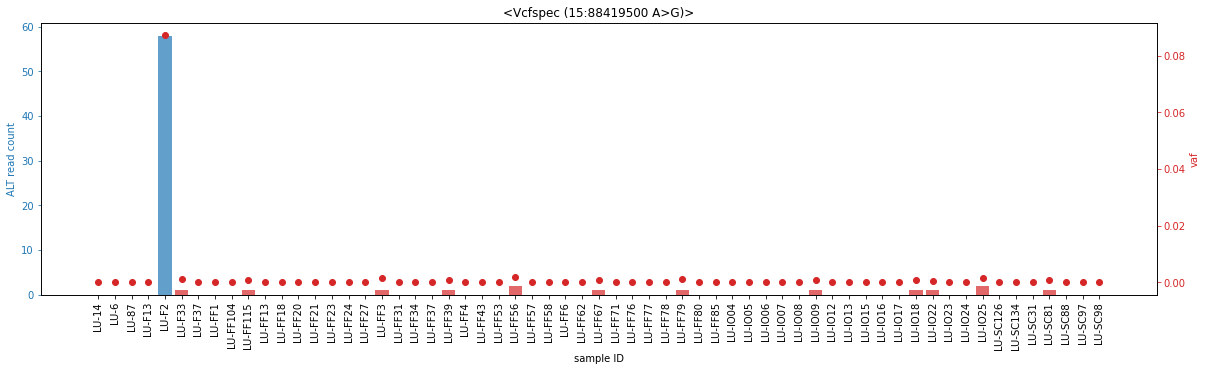

pon filter
okay samples ['LU-F2']
values {'LU-14': 0.0, 'LU-6': 0.0, 'LU-87': 0.0, 'LU-F13': 0.0, 'LU-F2': 58.0, 'LU-F33': 1.0, 'LU-F37': 0.0, 'LU-FF1': 0.0, 'LU-FF104': 0.0, 'LU-FF115': 1.0, 'LU-FF13': 0.0, 'LU-FF18': 0.0, 'LU-FF20': 0.0, 'LU-FF21': 0.0, 'LU-FF23': 0.0, 'LU-FF24': 0.0, 'LU-FF27': 0.0, 'LU-FF3': 1.0, 'LU-FF31': 0.0, 'LU-FF34': 0.0, 'LU-FF37': 0.0, 'LU-FF39': 1.0, 'LU-FF4': 0.0, 'LU-FF43': 0.0, 'LU-FF53': 0.0, 'LU-FF56': 2.0, 'LU-FF57': 0.0, 'LU-FF58': 0.0, 'LU-FF6': 0.0, 'LU-FF62': 0.0, 'LU-FF67': 1.0, 'LU-FF71': 0.0, 'LU-FF76': 0.0, 'LU-FF77': 0.0, 'LU-FF78': 0.0, 'LU-FF79': 1.0, 'LU-FF80': 0.0, 'LU-FF85': 0.0, 'LU-IO04': 0.0, 'LU-IO05': 0.0, 'LU-IO06': 0.0, 'LU-IO07': 0.0, 'LU-IO08': 0.0, 'LU-IO09': 1.0, 'LU-IO12': 0.0, 'LU-IO13': 0.0, 'LU-IO15': 0.0, 'LU-IO16': 0.0, 'LU-IO17': 0.0, 'LU-IO18': 1.0, 'LU-IO22': 1.0, 'LU-IO23': 0.0, 'LU-IO24': 0.0, 'LU-IO25': 2.0, 'LU-SC126': 0.0, 'LU-SC134': 0.0, 'LU-SC31': 0.0, 'LU-SC81': 1.0, 'LU-SC88': 0.0, 'LU-SC97': 0.0, 'LU-SC98'

In [4218]:
def show_filter_result(filter_result, title):
    print(title)
    print('okay samples', list(itertools.compress(SAMPLEIDS_LU, filter_result['mask'])))
    print('values', dict(zip(SAMPLEIDS_LU, filter_result['values'])))
    print()

# run filter functions
ponfilter_result = pon_filter(vp, n_sample_cutoff=5, ratio_cutoff=10, minsubset_fraction=0.5, mode='mean')
bqfilter_result = BQ_filter(vp, diff_cutoff=-10)
mqfilter_result = MQ_filter(vp, diff_cutoff=-15)
mqfilter_ref_result = MQ_filter_REF(vp, cutoff=40)
clipovlpfilter_result = clipoverlap_filter(vp, ratio_cutoff=3)
# varposfilter_result = varpos_filter(vp, pval_cutoff=0.01)
altcountfilter_result = altcount_filter(vp, cutoff=3)
othercountfilter_result = othercount_filter(vp, ratio_cutoff=2)

# intersect masks
# mask = functools.reduce(np.logical_and, [ponmask])
mask = functools.reduce(np.logical_and, [ponfilter_result['mask'], 
                                         bqfilter_result['mask'], 
                                         mqfilter_result['mask'], 
                                         mqfilter_ref_result['mask'],
                                         clipovlpfilter_result['mask'], 
#                                          varposfilter_result['mask'],
                                         altcountfilter_result['mask'],
                                         othercountfilter_result['mask'],
                                         ])
all_okay_samples = list(itertools.compress(SAMPLEIDS_LU, mask))

# plotting
show_vp_altcounts(vp, mask, logscale_count=False)

# print results
show_filter_result(ponfilter_result, 'pon filter')
show_filter_result(bqfilter_result, 'BQ filter')
show_filter_result(mqfilter_result, 'MQ filter')
show_filter_result(mqfilter_ref_result, 'MQ filter REF value')
show_filter_result(clipovlpfilter_result, 'softclip-overlap filter')
# show_filter_result(varposfilter_result, 'variant position filter')
show_filter_result(altcountfilter_result, 'ALT read count filter')
show_filter_result(othercountfilter_result, 'other-supporting read ratio filter')

print('all okay samples', all_okay_samples)

bait_end_distance = get_bait_end_distance(vp)
print('bait end distance', bait_end_distance)

In [4222]:
# sampleid = all_okay_samples[0]
sampleid = 'LU-FF115'

print(sampleid)

LU-FF115


In [4223]:
show_vp_igv(vp, sampleid)

OK
OK
OK
OK
OK
OK
OK
OK
OK
OK


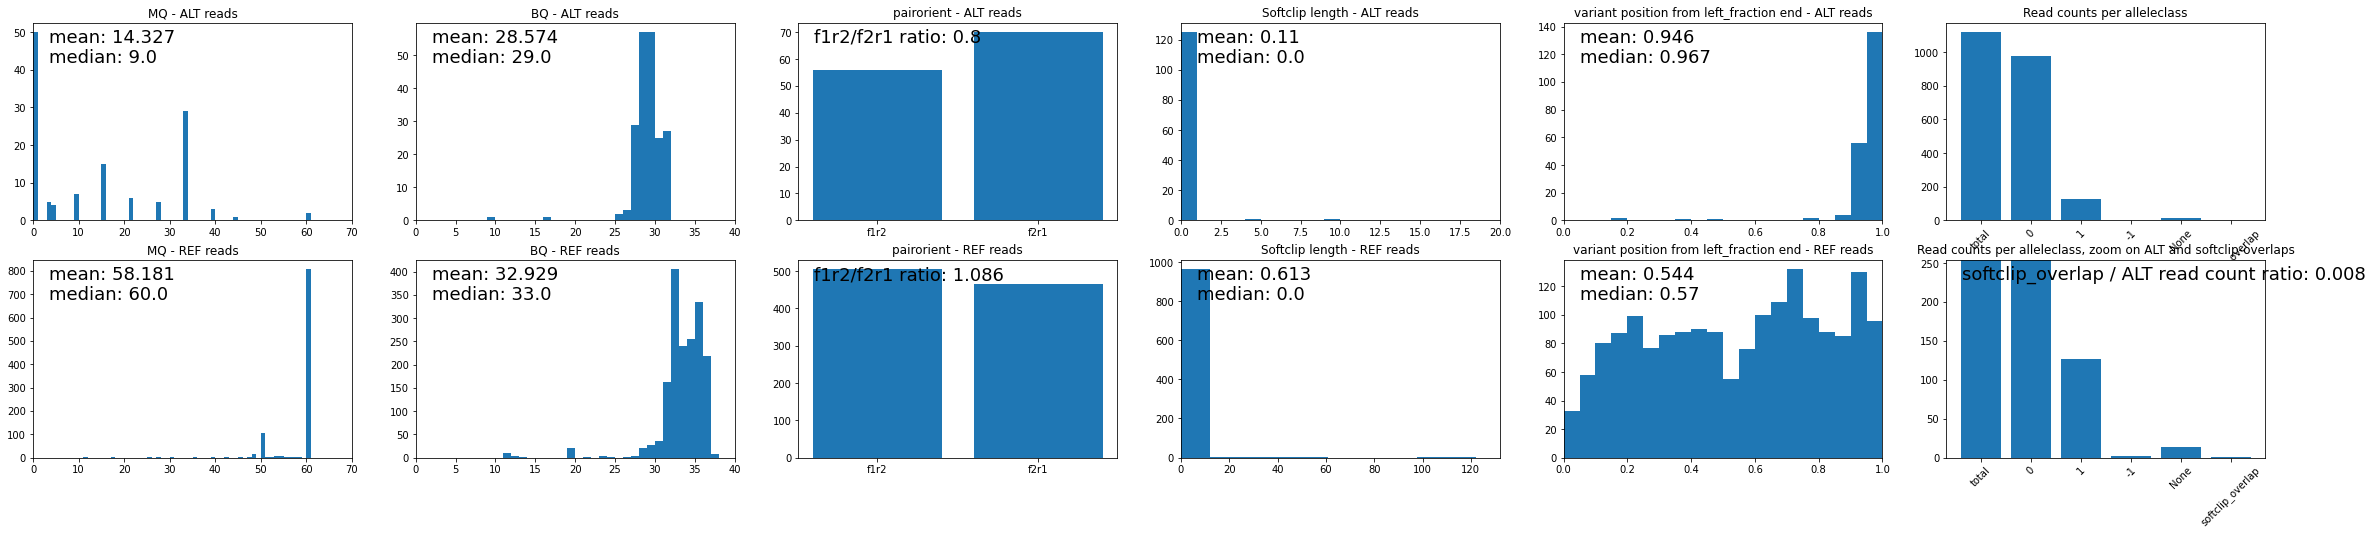

In [4147]:
show_vp_readstats(vp, sampleid, varpos_key='left_fraction')

In [337]:
vp.get_pon()

{'total_depth': 67893, 'alt_depth': 1106, 'alt_vaf': 0.016290339210227857}

In [341]:
vp.annotdb.transcript_canon

{'ENST00000301067': {'aa_change': ['Q', '*'],
                     'biotype': 'protein_coding',
                     'ccds_id': 'CCDS44873.1',
                     'chrom': 12,
                     'codon_change': ['Cag', 'Tag'],
                     'codon_frame0': 0,
                     'consequence_flags': {'is_3pUTR_involved': False,
                                           'is_5pUTR_involved': False,
                                           'is_SV_consequence': False,
                                           'is_frameshift': False,
                                           'is_missense': False,
                                           'is_not_protein_altering': False,
                                           'is_protein_altering': True,
                                           'is_splice_acceptor_involved': False,
                                           'is_splice_donor_involved': False,
                                           'is_splice_region_involved': False

In [342]:
pprint.pprint({x: (vp.get_vaf(x), vp.vr.samples[x]['allele_readcounts'][3]) 
               for x in SAMPLEIDS_LU})

{'LU-14': (0.0, 0),
 'LU-6': (0.0014792899408284023, 1),
 'LU-87': (0.0, 0),
 'LU-F13': (0.0, 0),
 'LU-F2': (0.0, 0),
 'LU-F33': (0.0018674136321195146, 2),
 'LU-F37': (0.0, 0),
 'LU-FF1': (0.0, 0),
 'LU-FF104': (0.0, 0),
 'LU-FF115': (0.0, 0),
 'LU-FF13': (0.0, 0),
 'LU-FF18': (0.0, 0),
 'LU-FF20': (0.0010845986984815619, 1),
 'LU-FF21': (0.0, 0),
 'LU-FF23': (0.0, 0),
 'LU-FF24': (0.0, 0),
 'LU-FF27': (0.0, 0),
 'LU-FF3': (0.0, 0),
 'LU-FF31': (0.0, 0),
 'LU-FF34': (0.0010626992561105207, 1),
 'LU-FF37': (0.0, 0),
 'LU-FF39': (0.0, 0),
 'LU-FF4': (0.0, 0),
 'LU-FF43': (0.0013386880856760374, 1),
 'LU-FF53': (0.0, 0),
 'LU-FF56': (0.0, 0),
 'LU-FF57': (0.0, 0),
 'LU-FF58': (0.0008936550491510277, 1),
 'LU-FF6': (0.0012610340479192938, 1),
 'LU-FF62': (0.0008944543828264759, 1),
 'LU-FF67': (0.0, 0),
 'LU-FF71': (0.0, 0),
 'LU-FF76': (0.0, 0),
 'LU-FF77': (0.0, 0),
 'LU-FF78': (0.0, 0),
 'LU-FF79': (0.0025188916876574307, 2),
 'LU-FF80': (0.0, 0),
 'LU-FF85': (0.0, 0),
 'LU-IO04': (0.0

### Plotting

In [214]:
cosmic = [(0
           if vp.annotdb.cosmic['total_occurrence'] is None else
           vp.annotdb.cosmic['total_occurrence']) 
          for vp in vcfp.vplist_filtered]

In [262]:
alt_counts = np.array(list(itertools.chain.from_iterable(
    [x['allele_readcounts'][-1] for x in vp.vr.samples.values()]
    for vp in vcfp.vplist_filtered
)))

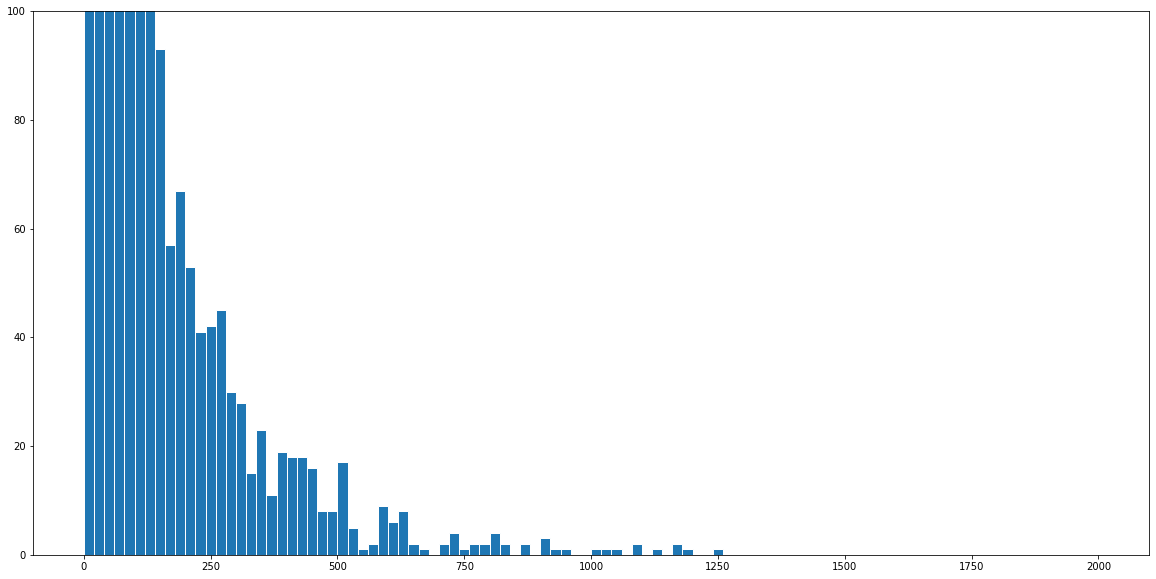

In [506]:
fig, ax = plt.subplots(figsize=(20,10))
ax.hist(alt_counts, 
        bins=100, 
        range=(0, 2000),
        edgecolor='white')
ax.set(ylim=(0, 100))
plt.show()

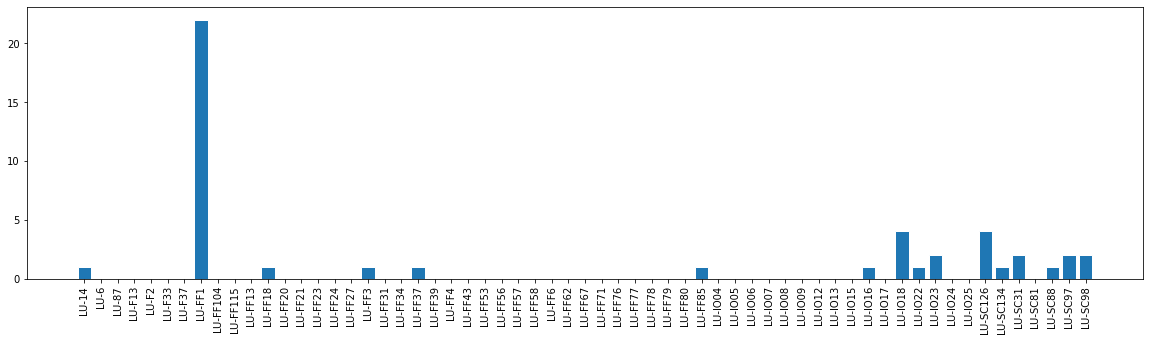

In [17]:
altcnts = np.array([vp.vr.samples[sampleid]['allele_readcounts'][-1] for sampleid in SAMPLEIDS_LU])
totalcnts = np.array([sum(vp.vr.samples[sampleid]['allele_readcounts'][1:]) for sampleid in SAMPLEIDS_LU])
vaf = altcnts / totalcnts

fig, ax = plt.subplots(figsize=(20,5))
ax.bar(np.arange(len(altcnts)), altcnts, edgecolor='white')
ax.set(xticks=np.arange(len(altcnts)), 
       xticklabels=SAMPLEIDS_LU)
ax.tick_params(axis='x', direction='out', labelrotation=90)
plt.show()

### Inspect IGV

In [374]:
igv.cmd('new')
igv.load([PANEL_REGION_PATH])
load_bams('IO17')

OK
OK
OK
OK
OK


In [391]:
igv.goto([vp.vcfspec], width=100)
igv.cmd('viewaspairs')
igv.cmd('sort base')

OK
OK
OK


### Scratches

In [5]:
import pysam

import sys
sys.path.append('/home/users/pjh/scripts/python_genome_packages')

from handygenome.common import ChromDict, Vcfspec, Interval
from handygenome.variantplus.breakends import Breakends
from handygenome.variantplus.variantplus import VariantPlus
from handygenome.variantplus.vcfplus import VcfPlus
from handygenome import igvhandle

vcf_path = '/home/users/team_projects/Lung_Cancer_Panel_data/03_Data_from_YTKim/09_short_variants_union/220531/04_panel_union_all/panel_union.annot.readstats.vcf.gz'
vcf = pysam.VariantFile(vcf_path)
vr = next(vcf.fetch())
# print(vr)

In [452]:
def vpfilter01(vp):
    return max(vp.get_popfreq('GnomAD'), vp.get_popfreq('1000Genomes')) < 0.05

def vpfilter02(vp):
    return (vp.get_cosmic_total_occur() > 100)

def vpfilter03(vp):
    max_alt_count = max(vp.vr.samples[sid]['allele_readcounts'][-1] for sid in SAMPLEIDS_LU)
    return max_alt_count > 1000

def vpfilter04(vp):
    alt_counts = [vp.vr.samples[sid]['allele_readcounts'][-1] for sid in SAMPLEIDS_LU]
    return any(x in range(10, 20) for x in alt_counts)

def vpfilter05(vp):
    altread_sample_count = sum([vp.vr.samples[sid]['allele_readcounts'][-1] > 0 for sid in SAMPLEIDS_LU])
    return altread_sample_count in range(0, 10)

###

def vpfilter(vp):
    return vpfilter01(vp) and vpfilter02(vp)
#     return vpfilter01(vp) and vpfilter05(vp)

vcfp.filter_vplist(vpfilter)
print(len(vcfp.vplist_filtered))

19


In [491]:
# vp = vcfp.vplist_filtered.draw()
vp = vcfp.vplist_filtered[6]
# vp = next(filter(lambda vp: vp.vcfspec.pos == 25398285, vcfp.vplist_filtered))
# vp = next(filter(lambda vp: vp.vcfspec.pos == 7577547, vcfp.vplist_filtered))

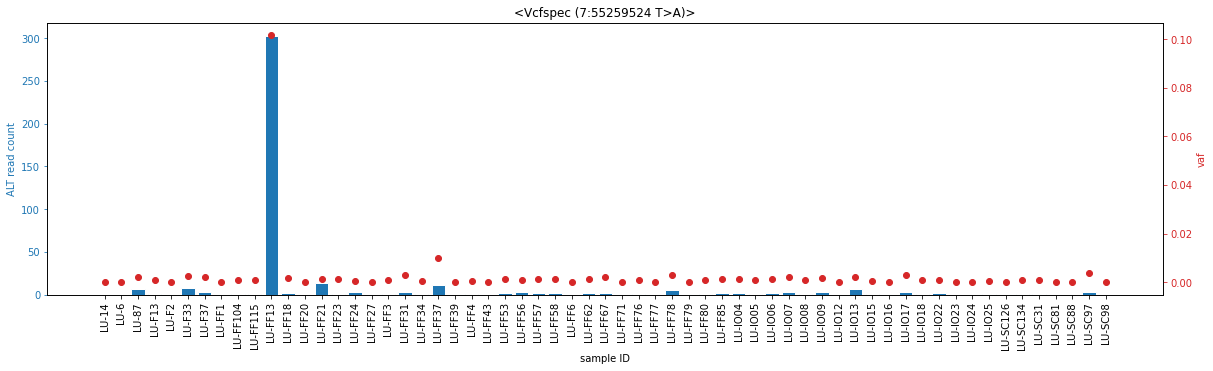

In [492]:
altcnts = np.array([vp.vr.samples[sampleid]['allele_readcounts'][-1] for sampleid in SAMPLEIDS_LU])
totalcnts = np.array([sum(vp.vr.samples[sampleid]['allele_readcounts'][1:]) for sampleid in SAMPLEIDS_LU])
vaf = altcnts / totalcnts
x = np.arange(len(altcnts))
# zscore_cnt = scipy.stats.zscore(altcnts)
# zscore_vaf = scipy.stats.zscore(vaf)

# import sklearn.neighbors
# clf = sklearn.neighbors.LocalOutlierFactor(4)
# is_inliner_cnt = clf.fit_predict([[x] for x in altcnts])
# is_inliner_vaf = clf.fit_predict([[x] for x in vaf])

y_map = {
    'count': {'value': altcnts, 'label': 'ALT read count'},
    'count_z': {'value': zscore_cnt, 'label': 'z-score of count'},
#     'count_lof': {'value': is_inliner_cnt, 'label': 'LOF of count'},
    'vaf': {'value': vaf, 'label': 'vaf'},
    'vaf_z': {'value': zscore_vaf, 'label': 'z-score of vaf'},
#     'vaf_lof': {'value': is_inliner_vaf, 'label': 'LOF of vaf'},
}
# y1_key = 'count' ; y2_key = 'count_lof'
y1_key = 'count' ; y2_key = 'vaf'
# y1_key = 'vaf' ; y2_key = 'vaf_z'

y1_map = y_map[y1_key] ; y2_map = y_map[y2_key]
y1 = y1_map['value']
ylabel1 = y1_map['label']
y2 = y2_map['value']
ylabel2 = y2_map['label']

title = str(vp.vcfspec)

col_ax1 = 'tab:blue'
col_ax2 = 'tab:red'

fig, ax1 = plt.subplots(figsize=(20,5))
ax1.bar(x, y1, edgecolor='white', color=col_ax1)
ax1.set(title=title,
        xticks=np.arange(len(altcnts)), 
        xticklabels=SAMPLEIDS_LU)
# ax1.set(ylim=(0, 20))
ax1.set_xlabel('sample ID')
ax1.tick_params(axis='x', direction='out', labelrotation=90)
ax1.set_ylabel(ylabel1, color=col_ax1)
ax1.tick_params(axis='y', color=col_ax1, labelcolor=col_ax1)

ax2 = ax1.twinx()
ax2.scatter(x, y2, color=col_ax2)
# ax2.set(ylim=(0, 0.5))
# ax2.set(ylim=(0, 1))
ax2.set_ylabel(ylabel2, color=col_ax2)
ax2.tick_params(axis='y', color=col_ax2, labelcolor=col_ax2)

plt.show()

In [494]:
altcnts_nonzero = altcnts[altcnts > 0]
altcnts_minsubset = sorted(altcnts_nonzero)[:int(len(altcnts_nonzero) * 0.5)]
print(altcnts_nonzero)
print(altcnts_minsubset)
mean_minsubset = np.mean(altcnts_minsubset)
max_minsubset = np.max(altcnts_minsubset)
median_minsubset = np.median(altcnts_minsubset)

altread_sample_count = sum(altcnts > 0)
ratio_mean_minsubset = altcnts / mean_minsubset
ratio_max_minsubset = altcnts / max_minsubset
ratio_median_minsubset = altcnts / median_minsubset

print('altread_sample_count', altread_sample_count)

print('ratio_mean_minsubset', ratio_mean_minsubset)
print('max ratio_mean_minsubset', np.max(ratio_mean_minsubset))

print('ratio_max_minsubset', ratio_max_minsubset)
print('max ratio_max_minsubset', np.max(ratio_max_minsubset))

print('ratio_median_minsubset', ratio_median_minsubset)
print('max ratio_median_minsubset', np.max(ratio_median_minsubset))

[  7   1   8   3   1   1 303   2  14   1   3   1   3   1  11   1   2   3
   2   2   2   2   1   5   1   2   2   1   2   3   1   3   6   1   3   1
   2   1   1   1   3]
[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 2, 2, 2, 2]
altread_sample_count 41
ratio_mean_minsubset [  0.           0.           5.83333333   0.83333333   0.
   6.66666667   2.5          0.           0.83333333   0.83333333
 252.5          1.66666667   0.          11.66666667   0.83333333
   2.5          0.           0.83333333   2.5          0.83333333
   9.16666667   0.           0.83333333   0.           1.66666667
   2.5          1.66666667   1.66666667   0.           1.66666667
   1.66666667   0.           0.83333333   0.           4.16666667
   0.           0.83333333   1.66666667   1.66666667   0.83333333
   1.66666667   2.5          0.83333333   2.5          0.
   5.           0.83333333   0.           2.5          0.83333333
   1.66666667   0.           0.           0.83333333   0.
   0.83333333   0.833333

In [478]:
np.nonzero([0,0,1,2,3,0,0])

(array([2, 3, 4]),)

In [460]:
sampleid = 'SC81'

igv.cmd('new')
igv.load([PANEL_REGION_PATH])
load_bams(sampleid)

igv.goto([vp.vcfspec], width=200)
igv.cmd('viewaspairs')
igv.cmd('sort base')

OK
OK
OK
OK
OK
OK
OK
OK


In [259]:
sampleid = 'SC98'
rpplist = vp.get_rpplist(BAMS['panel'][sampleid])
rpplist.update_alleleinfo(vp.vcfspec)
readcounts = rpplist.get_readcounts(vp.vcfspec)
print(readcounts)

{None: 13, -1: 2, 0: 1520, 1: 4}


In [253]:
9 / (2177+10+9)

0.004098360655737705

# LU-IO16 filtering

In [83]:
igv = igvhandle.IGVHandle(port=60387)

In [280]:
vcf_path = '/home/users/team_projects/Lung_Cancer_Panel_data/03_Data_from_YTKim/09_short_variants_union/220531/LU-IO16.panel.Mutect2_Strelka2_union.vcf.gz'

In [88]:
load_bams('IO16')

OK
OK
OK


In [145]:
igv.cmd('viewaspairs')
igv.cmd('group')

OK
OK


In [239]:
vcfp = VcfPlus(vcf_path, set_annotdb=False)

[KST 2022-06-03 03:54:09 INFO] LU-IO16.panel.Mutect2_Strelka2_union.vcf.gz: 10000 variant records processed
[KST 2022-06-03 03:54:09 INFO] LU-IO16.panel.Mutect2_Strelka2_union.vcf.gz: 10000 variant records processed
[KST 2022-06-03 03:54:09 INFO] LU-IO16.panel.Mutect2_Strelka2_union.vcf.gz: 10000 variant records processed
[KST 2022-06-03 03:54:09 INFO] LU-IO16.panel.Mutect2_Strelka2_union.vcf.gz: 10000 variant records processed
[KST 2022-06-03 03:54:09 INFO] LU-IO16.panel.Mutect2_Strelka2_union.vcf.gz: 10000 variant records processed


In [240]:
vcfp.filter_isec(PANEL_REGION_GR)

In [279]:
vcfp

<VcfPlus object>
- refver: hg19
- vplist:
    [<VariantPlus object (1	726130	.	A	C)>,
     <VariantPlus object (1	821169	.	A	T)>,
     <VariantPlus object (1	821190	.	A	T)>,
     <VariantPlus object (1	821206	.	T	C)>,
     <VariantPlus object (1	821253	.	C	T)>,
     <VariantPlus object (1	826026	.	T	C)>,
     <VariantPlus object (1	1005202	.	G	C)>,
     <VariantPlus object (1	1158429	.	T	G)>,
     <VariantPlus object (1	1355646	.	G	A)>,
     <VariantPlus object (1	1572577	.	G	A)>,
     <VariantPlus object (1	1576623	.	G	A)>,
     <VariantPlus object (1	1576636	.	G	A)>,
     <VariantPlus object (1	1586719	.	C	T)>,
     <VariantPlus object (1	1649598	.	C	T)>,
     <VariantPlus object (1	1649608	.	C	T)>,
     <VariantPlus object (1	2118524	.	G	T)>,
     <VariantPlus object (1	2424558	.	G	T)>,
     <VariantPlus object (1	2431878	.	G	T)>,
     <VariantPlus object (1	2584486	.	C	A)>,
     <VariantPlus object (1	2619606	.	C	A)>,
     <VariantPlus object (1	2622651	.	G	C)>,
     <VariantPlus o

In [281]:
len([vp for vp in vcfp.vplist_filtered
     if vp.get_alleleinfo_stat(BAMS['panel']['IO16'], no_matesearch=True)[1] == 0])

48

In [242]:
vp = random.choice(vcfp.vplist_filtered)

In [264]:
vp

<VariantPlus object (12	56489583	.	G	A)>

In [263]:
igv.goto([vp.vcfspec], width=100)
igv.cmd('viewaspairs')
igv.cmd('sort base')

OK
OK
OK


In [275]:
pon = vp.get_pon_info(BAMS['panel'], no_matesearch=True)

In [277]:
df_pon = pd.DataFrame.from_dict(pon, orient='index').sort_index()

In [260]:
igv.cmd('new')
load_bams('SC31')

OK
OK
OK
OK


In [278]:
with pd.option_context('display.max_rows', None,):
    print(df_pon.sort_values(by=[1.0], ascending=False))

        NaN  -1.0   0.0   1.0
IO16      6     0   358     5
SC31     23     8  1138     3
SC88     10     7   868     2
IO05     18    13  1188     2
FF67     17     2  1064     1
IO17     27     9  1359     1
FF62     29     9  1639     1
FF85     13     5   966     1
FF56     21     6   957     1
FF53      9     5   815     1
FF43      9    12   814     1
IO09     18     3   917     1
FF27     13     2  1137     1
IO18     27     3  1196     1
IO23     10     6   804     1
SC126     5     4   879     1
IO25     29     9  1343     1
IO22     18     6  1195     1
IO24     15     7   848     1
FF78     18     7   992     1
IO12     20     5  1157     0
IO08     19     2  1046     0
IO07     12     4  1082     0
IO06     22     5  1166     0
IO13     12     6   813     0
FF77     13     2   972     0
IO15     11     2   914     0
SC134    17     8   804     0
IO04     16     6  1071     0
SC81     14     1  1184     0
SC97     13     3   631     0
FF80      5     4   893     0
FF79     1

In [274]:
for key in ('normal', 'tumor', 'panel'):
    print(key, vp.get_alleleinfo_stat(BAMS[key]['IO16'], no_matesearch=True))

normal {None: 1, -1: 0, 0: 58, 1: 0}
tumor {None: 2, -1: 0, 0: 60, 1: 0}
panel {None: 6, -1: 0, 0: 358, 1: 5}
